### Table of contents:

1. Hydrogeology
2. Permeability
3. Land Use
4. Soil Characteristics
5. Elevation



## 1. Hydrogeology

### Normalization of units

In [29]:
import pandas as pd

# Load the Excel file
file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/geologie_PCA.xlsx'
data = pd.read_excel(file_path)

# List of columns to normalize
land_use_columns = [
    'ANDS',
    'ASHT',	
    'BASA',	
    'BIGN',
    'CRMU',	
    'CRMS',	
    'CARE',	
    'CLAY',	
    'CLST',	
    'CONG',	
    'GNEI',
    'GRAN',	
    'LIME',	
    'PGSS',
    'RHYO',
    'SAND',	
    'SAST',	
    'SILT',	
    'SIST',	
    'SLAT',
    'TEPH',	
    'THBA'
]

# Normalize the land use columns by the catch_area for each messstelle
for col in land_use_columns:
    data[col] = data[col] / data['catch_area']

# Save the normalized dataframe to a new Excel file
output_file_path_normalized = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/normalized_hydrogeology.xlsx'
data.to_excel(output_file_path_normalized, index=False)

print("Normalized data saved to", output_file_path_normalized)

Normalized data saved to C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/normalized_hydrogeology.xlsx


###  Hydrogeology Uniq values aggregation 

In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/geologie/merged_geologie_cluster_gebid.xlsx'
excel_data = pd.ExcelFile(file_path)


data = pd.read_excel(file_path, sheet_name='Sheet1')

# Pivot Tabelle 'messstelle' (Index)'I_CompMat1' (Spalten),  'area_geol'(aggregierung)
pivot_corrected = data.pivot_table(
    index='messstelle', 
    columns='I_CompMat1', 
    values='area_geol', 
    aggfunc='sum', 
    fill_value=0
)


pivot_corrected.to_excel('C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/geologie/geologie_PCA.xlsx')
print(pivot_corrected.head())


#### Daten Merge mit overvie Tabelle 

In [ ]:
import pandas as pd

# Laden der Excel-Dateien
geologie_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\geologie\geologie_PCA.xlsx'
merged_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\merged_hierarchie_overview_updated.xlsx'

# Lesen der Daten
geologie_data = pd.read_excel(geologie_file_path, sheet_name='Sheet1')
merged_data = pd.read_excel(merged_file_path)

# Anzeigen der ersten Zeilen der Daten zur Überprüfung
print(geologie_data.head())
print(merged_data.head())

# Mergen der Daten anhand der Messstellen
merged_geologie_data = pd.merge(geologie_data, merged_data, how='left', left_on='messstelle', right_on='messstelle')

# Speichern der kombinierten Daten in einer neuen Excel-Datei
output_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\geologie\geologie_PCA_merged_overview.xlsx'
merged_geologie_data.to_excel(output_file_path, index=False)

print(f'Die kombinierten Daten wurden erfolgreich gespeichert in {output_file_path}')


### HYDROGEOLOGY STATISTICS

In [18]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Load the Excel file
file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/1_PCA_normalized_hydrogeology.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')

# Define soil categories with their original names and abbreviations
geo_categories = ['ANDS', 'ASHT', 'BASA', 'BIGN', 'CRMU', 'CRMS', 'CARE', 'CLAY',
    'CLST', 'CONG', 'GNEI', 'GRAN', 'LIME', 'PGSS', 'RHYO', 'SAND',
    'SAST', 'SILT', 'SIST', 'SLAT', 'TEPH', 'THBA']

# Filter data for 'ges_ezg' and 'teil_ezg'
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# Function to perform statistical tests
def perform_statistical_tests(data):
    numeric_data = data[geo_categories]
    clusters = data['cluster']
    results = []
    
    for col in numeric_data.columns:
        unit = col
        cluster_groups = [numeric_data[col][clusters == cluster_num].dropna() for cluster_num in range(1, 5)]
        
        # Check for variability in cluster groups
        if all(group.nunique() > 1 for group in cluster_groups if len(group) > 0):
            # Kruskal-Wallis Test
            kruskal_result = stats.kruskal(*cluster_groups)
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': kruskal_result.statistic,
                'P-Value': kruskal_result.pvalue,
                'Note': 'Significant differences' if kruskal_result.pvalue < 0.05 else 'Insufficient variance'
            }
            results.append(pd.DataFrame([result]))
            
            if kruskal_result.pvalue < 0.05:  # Only if Kruskal-Wallis is significant, perform post-hoc test
                dunn_result = sp.posthoc_dunn(cluster_groups, p_adjust='bonferroni')
                dunn_result = dunn_result.melt(var_name='Comparison', value_name='P-Value')
                dunn_result['Test'] = 'Dunn'
                dunn_result['Unit'] = unit
                results.append(dunn_result)
        else:
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': 'N/A',
                'P-Value': 'N/A',
                'Note': 'Insufficient variance'
            }
            results.append(pd.DataFrame([result]))

    return pd.concat(results)

# Perform tests for 'ges_ezg' and 'teil_ezg'
ges_ezg_results = perform_statistical_tests(ges_ezg_data)
teil_ezg_results = perform_statistical_tests(teil_ezg_data)

# Save the results to Excel files
ges_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hydrogeo_ges_ezg_stats_results.xlsx'
teil_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hydrogeo_teil_ezg_stats_results.xlsx'

ges_ezg_results.to_excel(ges_ezg_results_path, index=False)
teil_ezg_results.to_excel(teil_ezg_results_path, index=False)

print("Results for 'ges_ezg' saved to:", ges_ezg_results_path)
print("Results for 'teil_ezg' saved to:", teil_ezg_results_path)



Results for 'ges_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hydrogeo_ges_ezg_stats_results.xlsx
Results for 'teil_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hydrogeo_teil_ezg_stats_results.xlsx


### Figure. Hydrogeology Distrbution 

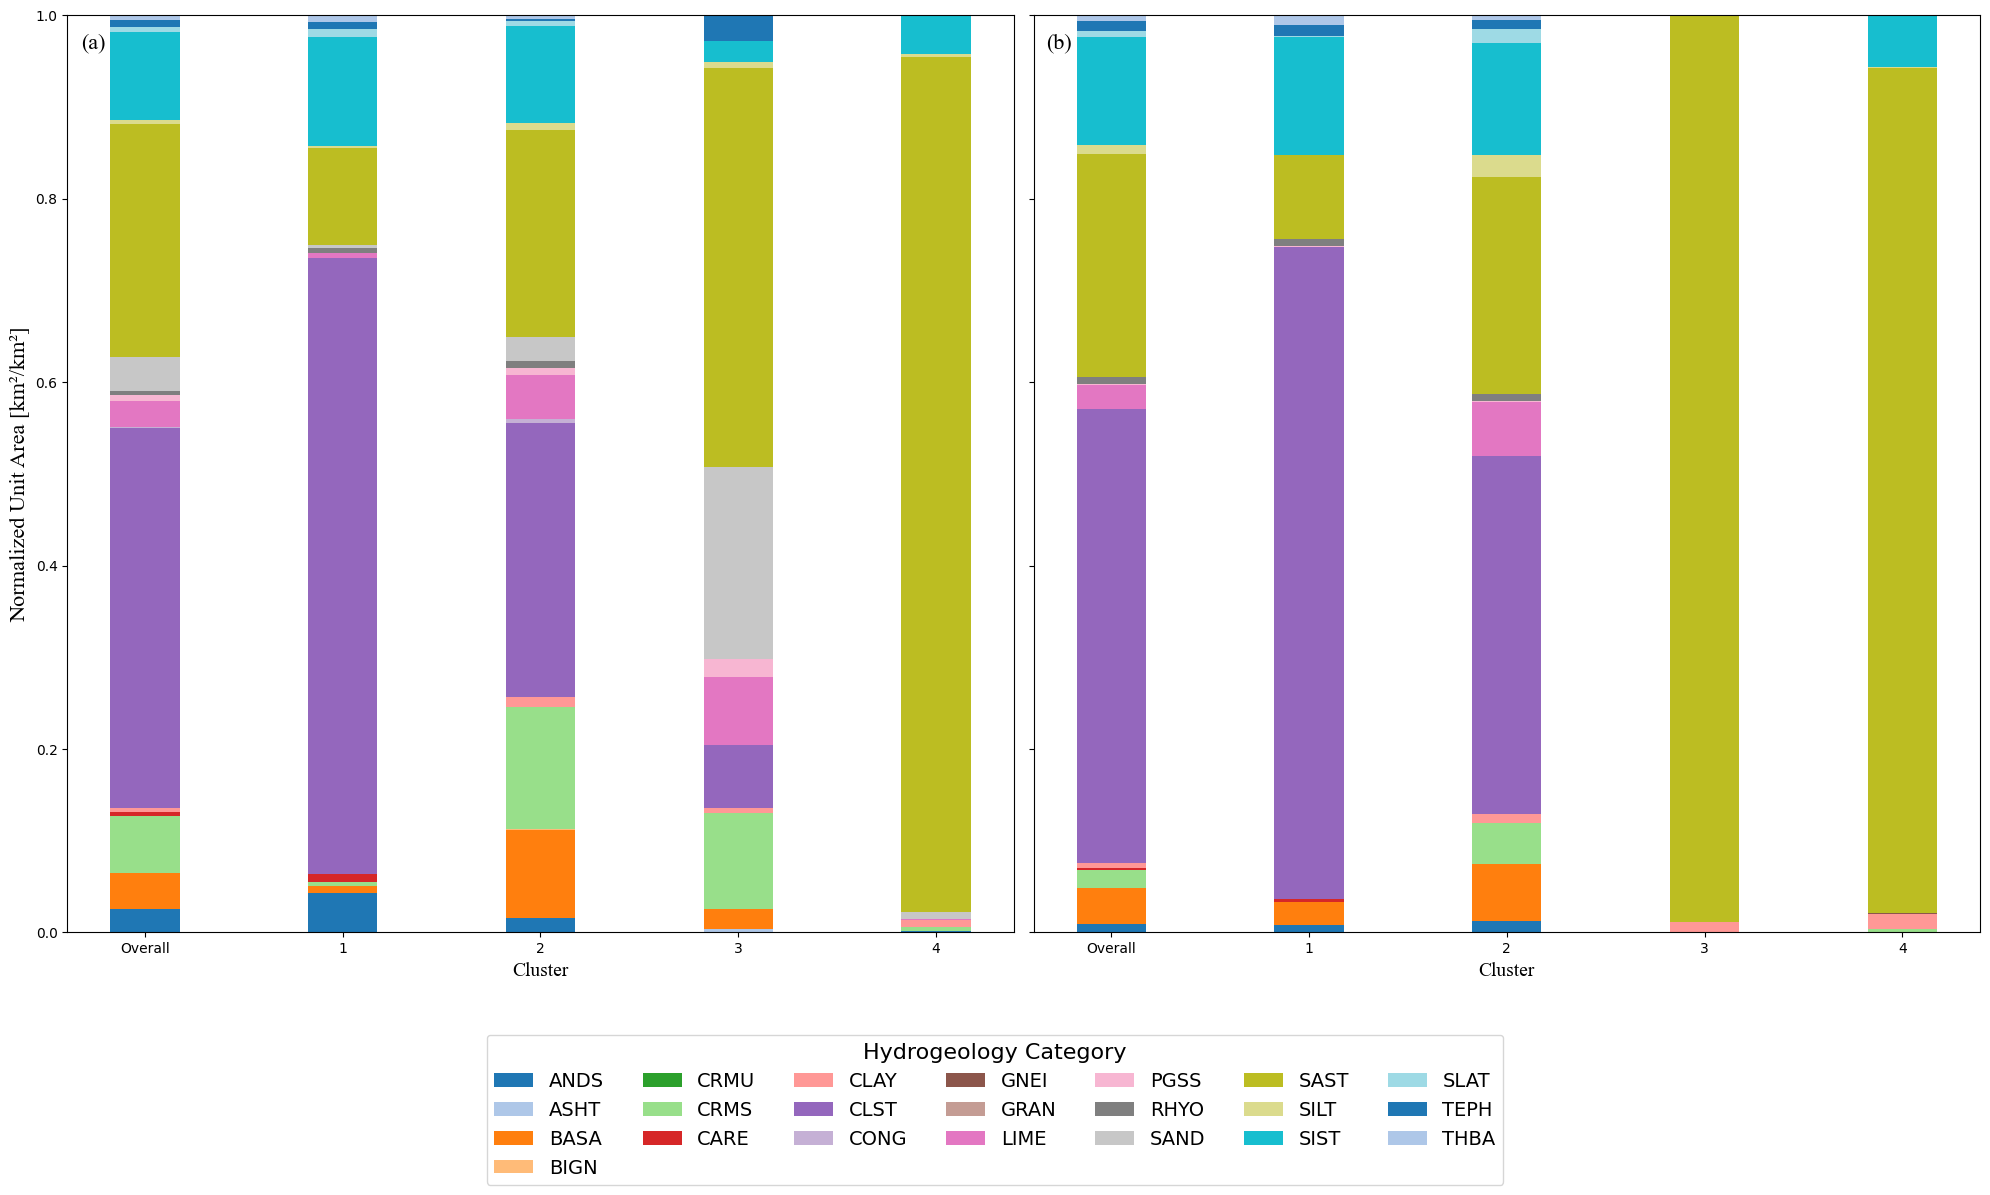

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/1_PCA_normalized_hydrogeology.xlsx'
data = pd.read_excel(file_path)

# Relevante Spalten
categories = [
    'ANDS', 'ASHT', 'BASA', 'BIGN', 'CRMU', 'CRMS', 'CARE', 'CLAY',
    'CLST', 'CONG', 'GNEI', 'GRAN', 'LIME', 'PGSS', 'RHYO', 'SAND',
    'SAST', 'SILT', 'SIST', 'SLAT', 'TEPH', 'THBA'
]

# Konvertiere Spalten in numerische Werte und behandle dabei Fehler
for col in categories:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Erstellung des Plots
def create_stacked_bar_plots(data, filename):
    # Filter 
    ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
    teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']
    
    # normalisierten Werte summieren für jede Permeabilitätskategorie und jeden Cluster
    ges_ezg_summed = ges_ezg_data.groupby('cluster')[categories].sum()
    teil_ezg_summed = teil_ezg_data.groupby('cluster')[categories].sum()
    
    # Overall Kategorie hinzufügen
    ges_ezg_summed.loc['Overall'] = ges_ezg_summed.sum()
    teil_ezg_summed.loc['Overall'] = teil_ezg_summed.sum()
    
    # Zuerst Overall
    ges_ezg_summed = ges_ezg_summed.loc[['Overall'] + sorted([i for i in ges_ezg_summed.index if isinstance(i, int)])]
    teil_ezg_summed = teil_ezg_summed.loc[['Overall'] + sorted([i for i in teil_ezg_summed.index if isinstance(i, int)])]
    
    # Normalisieren der summierten Werte durch die Gesamtsumme jedes Clusters
    ges_ezg_summed = ges_ezg_summed.div(ges_ezg_summed.sum(axis=1), axis=0)
    teil_ezg_summed = teil_ezg_summed.div(teil_ezg_summed.sum(axis=1), axis=0)
    
    
    indices_ges = ges_ezg_summed.index.astype(str)
    indices_teil = teil_ezg_summed.index.astype(str)
    
    # Farbpalette 
    custom_colors = sns.color_palette("tab20", len(categories))
    
    # Plotten
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
    
    width = 0.35  # Width ändern

    # Plot für ges_ezg
    bottom = None
    for i, col in enumerate(categories):
        if i == 0:
            bottom = ges_ezg_summed[col]
            ax1.bar(indices_ges, ges_ezg_summed[col], width=width, label=col, color=custom_colors[i])
        else:
            ax1.bar(indices_ges, ges_ezg_summed[col], width=width, bottom=bottom, label=col, color=custom_colors[i])
            bottom += ges_ezg_summed[col]
    
    ax1.set_xlabel('Cluster', fontsize=14, fontname='Times New Roman')
    ax1.set_ylabel('Normalized Unit Area [km²/km²]', fontsize=16, fontname='Times New Roman')
    ax1.text(0.04, 0.98, '(a)', transform=ax1.transAxes, fontsize=16, fontname='Times New Roman', va='top', ha='right')
    ax1.set_xticks(range(len(indices_ges)))
    ax1.set_xticklabels(indices_ges)

    # Plot für teil_ezg
    bottom = None
    for i, col in enumerate(categories):
        if i == 0:
            bottom = teil_ezg_summed[col]
            ax2.bar(indices_teil, teil_ezg_summed[col], width=width, label=col, color=custom_colors[i])
        else:
            ax2.bar(indices_teil, teil_ezg_summed[col], width=width, bottom=bottom, label=col, color=custom_colors[i])
            bottom += teil_ezg_summed[col]
    
    ax2.set_xlabel('Cluster', fontsize=14, fontname='Times New Roman')
    ax2.text(0.04, 0.98, '(b)', transform=ax2.transAxes, fontsize=16, fontname='Times New Roman', va='top', ha='right')
    ax2.set_xticks(range(len(indices_teil)))
    ax2.set_xticklabels(indices_teil)

    # Legende
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=7, fontsize=14, title='Hydrogeology Category', title_fontsize=16, bbox_to_anchor=(0.5, -0.2))
    
    plt.tight_layout()
    
    # Speichern SVG
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.show()


create_stacked_bar_plots(data, 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hydrogeology_overview.svg')



#### Hydrogeology Distributions: 

In [24]:
import pandas as pd

file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/1_PCA_normalized_hydrogeology.xlsx'
data = pd.read_excel(file_path)


categories = [
    'ANDS', 'ASHT', 'BASA', 'BIGN', 'CRMU', 'CRMS', 'CARE', 'CLAY',
    'CLST', 'CONG', 'GNEI', 'GRAN', 'LIME', 'PGSS', 'RHYO', 'SAND',
    'SAST', 'SILT', 'SIST', 'SLAT', 'TEPH', 'THBA'
]


for col in categories:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# normalisierten Werte summieren für jede kategorie und jeden Cluster
ges_ezg_summed = ges_ezg_data.groupby('cluster')[categories].sum()
teil_ezg_summed = teil_ezg_data.groupby('cluster')[categories].sum()


ges_ezg_summed.loc['Overall'] = ges_ezg_summed.sum()
teil_ezg_summed.loc['Overall'] = teil_ezg_summed.sum()

# Zuerst Overall
ges_ezg_summed = ges_ezg_summed.loc[['Overall'] + sorted([i for i in ges_ezg_summed.index if isinstance(i, int)])]
teil_ezg_summed = teil_ezg_summed.loc[['Overall'] + sorted([i for i in teil_ezg_summed.index if isinstance(i, int)])]


ges_ezg_summed = ges_ezg_summed.div(ges_ezg_summed.sum(axis=1), axis=0)
teil_ezg_summed = teil_ezg_summed.div(teil_ezg_summed.sum(axis=1), axis=0)


output = pd.DataFrame({
    'Kategorie': categories,
    'ges_ezg': ges_ezg_summed.loc['Overall'] * 100,
    'teil_ezg': teil_ezg_summed.loc['Overall'] * 100
})

# Merge mit Cluster
for cluster in ges_ezg_summed.index:
    if cluster != 'Overall':
        output[f'ges_ezg_cluster_{cluster}'] = ges_ezg_summed.loc[cluster] * 100
        output[f'teil_ezg_cluster_{cluster}'] = teil_ezg_summed.loc[cluster] * 100


output.to_excel('C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hydrogeology_distribution.xlsx', index=False)
print("File saved as 'hydrogeology_distribution.xlsx'")




File saved as 'hydrogeology_distribution.xlsx'


Results: 

CRMS	Kruskal-Wallis	20.26224283	0.000149771	Significant differences	
1 - 2 = 0.001171056
1 - 3 = 0.005338926

CLST	Kruskal-Wallis	23.92950398	2.5841E-05	Significant differences	

1 - 2 = 0.014180359
1 - 3 = 0.000662391
1 - 4 = 0.005412765

LIME	Kruskal-Wallis	7.072226599	0.06963095	Insufficient variance	

SAND	Kruskal-Wallis	10.58560886	0.014191268	Significant differences	

1 - 3 = 0.029707941
2 - 3 = 0.036621489


1 - 4 = 0.000439317
2 - 4 = 0.01784052

### Fig. Significant Units Geology

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9912\2198884728.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9912\2198884728.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9912\2198884728.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=

Kruskal-Wallis Test for CRMS: Statistic=20.262242832703986, P-Value=0.00014977098519422017
Dunn Test for CRMS:
          1         2         3         4
1  1.000000  0.001171  0.005339  0.139681
2  0.001171  1.000000  1.000000  1.000000
3  0.005339  1.000000  1.000000  1.000000
4  0.139681  1.000000  1.000000  1.000000
Kruskal-Wallis Test for CLST: Statistic=23.92950397735462, P-Value=2.584097532793932e-05
Dunn Test for CLST:
          1         2         3         4
1  1.000000  0.014180  0.000662  0.005413
2  0.014180  1.000000  0.585826  0.794676
3  0.000662  0.585826  1.000000  1.000000
4  0.005413  0.794676  1.000000  1.000000
Kruskal-Wallis Test for SAND: Statistic=10.58560885572666, P-Value=0.014191267599284761
Dunn Test for SAND:
          1         2         3         4
1  1.000000  1.000000  0.029708  0.655395
2  1.000000  1.000000  0.036621  0.683594
3  0.029708  0.036621  1.000000  1.000000
4  0.655395  0.683594  1.000000  1.000000


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9912\2198884728.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9912\2198884728.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9912\2198884728.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fon

Kruskal-Wallis Test for SAST: Statistic=18.25902306987213, P-Value=0.00038892392631350697
Dunn Test for SAST:
          1         2         3         4
1  1.000000  0.667990  0.133831  0.000439
2  0.667990  1.000000  1.000000  0.017841
3  0.133831  1.000000  1.000000  0.460088
4  0.000439  0.017841  0.460088  1.000000


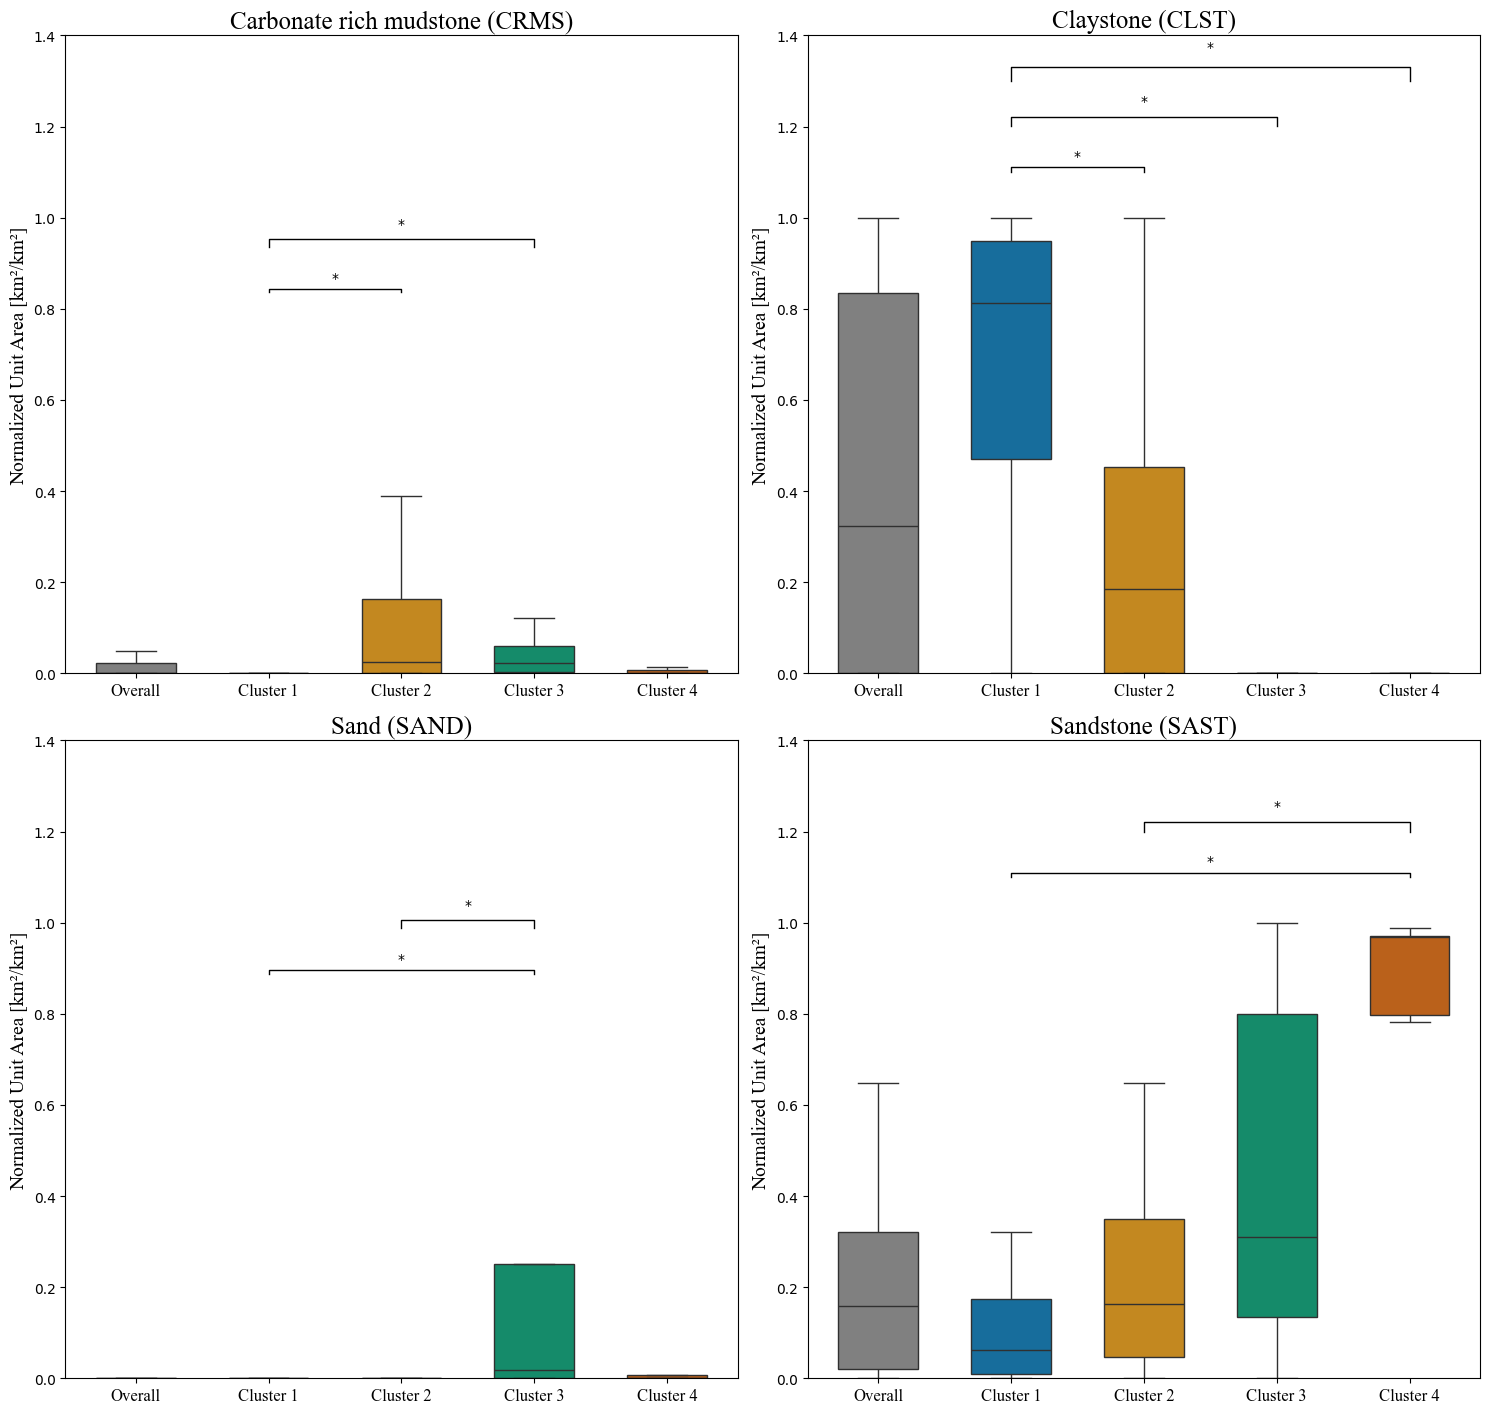

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/1_PCA_normalized_hydrogeology.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')


land_use_columns = ['CRMS', 'CLST', 'SAND', 'SAST']
titles = [
    'Carbonate rich mudstone (CRMS)',
    'Claystone (CLST)',
    'Sand (SAND)',
    'Sandstone (SAST)'
]

for col in land_use_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']

# Farbpalette
colorblind_palette = sns.color_palette("colorblind")
selected_colors = [colorblind_palette[i] for i in [0, 1, 2, 3]]  # Blue, Orange, Green, Red

# Boxplots Funktion
def create_boxplots_ges_ezg(data, title, filename):
    numeric_data = data[land_use_columns]
    
    # Set size
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # boxplots
    for i, col in enumerate(numeric_data.columns):
        # Combine overall data with cluster data for plotting
        overall_data = data.copy()
        overall_data['cluster'] = 'Overall'
        combined_data = pd.concat([overall_data, data])

        # Boxplots for each cluster including overall data
        sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
        
        # Set the title of the figure from the column title
        axes[i].set_title(titles[i], fontsize=18, fontname='Times New Roman')
        axes[i].set_ylim(0, 1.4)  # Set the y-axis to a maximum value of 1.4
        axes[i].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=14, fontname='Times New Roman')
        axes[i].set_xlabel('', fontsize=14, fontname='Times New Roman')
        axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')

        # Performing Kruskal-Wallis test
        kruskal_stat, kruskal_p = stats.kruskal(*[data[data['cluster'] == cluster][col] for cluster in data['cluster'].unique()])
        print(f'Kruskal-Wallis Test for {col}: Statistic={kruskal_stat}, P-Value={kruskal_p}')

        # If significant, perform Dunn's test
        if kruskal_p < 0.05:
            posthoc = posthoc_dunn(data, val_col=col, group_col='cluster', p_adjust='bonferroni')
            print(f'Dunn Test for {col}:\n{posthoc}')
            # Marking significant pairs from Dunn's test
            sig_pairs = []
            clusters = data['cluster'].unique()
            for k in range(len(clusters)):
                for j in range(k + 1, len(clusters)):
                    if posthoc.iloc[k, j] < 0.05:
                        sig_pairs.append((clusters[k], clusters[j], posthoc.iloc[k, j]))

            # Add significance markers from Dunn's test
            for idx, (x1, x2, p_value) in enumerate(sig_pairs):
                y_max = np.max(data[col])
                y_offset = y_max * 0.1 + idx * 0.1  # Increased spacing between markers
                axes[i].plot([x1, x1, x2, x2], [y_max + y_offset, y_max + y_offset * 1.1, y_max + y_offset * 1.1, y_max + y_offset], lw=1, c='black')
                axes[i].text((x1 + x2) * .5, y_max + y_offset * 1.2, "*", ha='center', va='bottom', color='black', fontsize=10)

    # Layout
    plt.suptitle(title, fontsize=18, fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, format='svg')
    plt.show()

# output path
output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/Abbildungen/'

#  boxplots for ges_ezg
create_boxplots_ges_ezg(ges_ezg_data, '', output_path + 'hydrogeology_ges_ezg_significant.svg')

## 2. Permeability

### Permeability Vorbereitung

In [ ]:
import pandas as pd


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/geologie/merged_geologie_cluster_gebid.xlsx'
excel_data = pd.ExcelFile(file_path)
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Create the pivot table
pivot_corrected = data.pivot_table(
    index='messstelle', 
    columns='kf', 
    values='area_geol', 
    aggfunc='sum', 
    fill_value=0
)

# Save
pivot_corrected.to_excel('C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/geologie/kf_PCA.xlsx')

# Display the first few rows
print(pivot_corrected.head())

### Permeability Merge

In [ ]:
import pandas as pd

# Laden der Excel-Dateien
geologie_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\geologie\kf_PCA.xlsx'
merged_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\merged_hierarchie_overview_updated.xlsx'

# Lesen der Daten
geologie_data = pd.read_excel(geologie_file_path, sheet_name='Sheet1')
merged_data = pd.read_excel(merged_file_path)

# Anzeigen der ersten Zeilen der Daten zur Überprüfung
print(geologie_data.head())
print(merged_data.head())

# Mergen der Daten anhand der Messstellen
merged_geologie_data = pd.merge(geologie_data, merged_data, how='left', left_on='messstelle', right_on='messstelle')

# Speichern der kombinierten Daten in einer neuen Excel-Datei
output_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\geologie\kf_PCA_merged_overview.xlsx'
merged_geologie_data.to_excel(output_file_path, index=False)

print(f'Die kombinierten Daten wurden erfolgreich gespeichert in {output_file_path}')


### Distribution of Permeability

In [37]:
import pandas as pd


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/2_PCA_normalized_kf_merged_overview.xlsx'
data = pd.read_excel(file_path)

categories = [
'High', 'Medium', 'Moderate', 'Low', 'Very low', 'Extremely low', 
              'Medium to moderate', 'Low to extremely low', 'Highly variable', 'Moderate to low']


for col in categories:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# Sum the normalized values for each permeability category and each cluster
ges_ezg_summed = ges_ezg_data.groupby('cluster')[categories].sum()
teil_ezg_summed = teil_ezg_data.groupby('cluster')[categories].sum()

# Overall zuerst
ges_ezg_summed.loc['Overall'] = ges_ezg_summed.sum()
teil_ezg_summed.loc['Overall'] = teil_ezg_summed.sum()

# Reorder: "Overall" zuerst
ges_ezg_summed = ges_ezg_summed.loc[['Overall'] + sorted([i for i in ges_ezg_summed.index if isinstance(i, int)])]
teil_ezg_summed = teil_ezg_summed.loc[['Overall'] + sorted([i for i in teil_ezg_summed.index if isinstance(i, int)])]

# Normalisieren
ges_ezg_summed = ges_ezg_summed.div(ges_ezg_summed.sum(axis=1), axis=0)
teil_ezg_summed = teil_ezg_summed.div(teil_ezg_summed.sum(axis=1), axis=0)


output = pd.DataFrame({
    'Kategorie': categories,
    'ges_ezg': ges_ezg_summed.loc['Overall'] * 100,
    'teil_ezg': teil_ezg_summed.loc['Overall'] * 100
})

# Merge 
for cluster in ges_ezg_summed.index:
    if cluster != 'Overall':
        output[f'ges_ezg_cluster_{cluster}'] = ges_ezg_summed.loc[cluster] * 100
        output[f'teil_ezg_cluster_{cluster}'] = teil_ezg_summed.loc[cluster] * 100


output.to_excel('C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/permeability_distribution.xlsx', index=False)
print("File saved as 'permeability_distribution.xlsx'")

File saved as 'permeability_distribution.xlsx'


### Fig. Distribution Permeability Overview

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/2_PCA_normalized_kf_merged_overview.xlsx'
data = pd.read_excel(file_path)

categories = ['High', 'Medium', 'Moderate', 'Low', 'Very low', 'Extremely low', 
              'Medium to moderate', 'Low to extremely low', 'Highly variable', 'Moderate to low']


for col in categories:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Plot Funktion
def create_stacked_bar_plots(data, filename):
    # Filter 
    ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
    teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']
    
    # Normalisieren
    ges_ezg_summed = ges_ezg_data.groupby('cluster')[categories].sum()
    teil_ezg_summed = teil_ezg_data.groupby('cluster')[categories].sum()
    
    #  "Overall" categorie (cluster sum)
    ges_ezg_summed.loc['Overall'] = ges_ezg_summed.sum()
    teil_ezg_summed.loc['Overall'] = teil_ezg_summed.sum()
    
    #  "Overall" zuerst
    ges_ezg_summed = ges_ezg_summed.loc[['Overall'] + sorted([i for i in ges_ezg_summed.index if isinstance(i, int)])]
    teil_ezg_summed = teil_ezg_summed.loc[['Overall'] + sorted([i for i in teil_ezg_summed.index if isinstance(i, int)])]
    
    # Normalize 
    ges_ezg_summed = ges_ezg_summed.div(ges_ezg_summed.sum(axis=1), axis=0)
    teil_ezg_summed = teil_ezg_summed.div(teil_ezg_summed.sum(axis=1), axis=0)
    
    
    indices_ges = ges_ezg_summed.index.astype(str)
    indices_teil = teil_ezg_summed.index.astype(str)
    
    # Farbpalette
    colorblind_palette = sns.color_palette("colorblind", len(categories))
    
    # Plotten
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
    
    width = 0.35  # Width of the bars

    # Plot for ges_ezg
    bottom = None
    for i, col in enumerate(categories):
        if i == 0:
            bottom = ges_ezg_summed[col]
            ax1.bar(indices_ges, ges_ezg_summed[col], width=width, label=col, color=colorblind_palette[i])
        else:
            ax1.bar(indices_ges, ges_ezg_summed[col], width=width, bottom=bottom, label=col, color=colorblind_palette[i])
            bottom += ges_ezg_summed[col]
    
    ax1.set_xlabel('Cluster', fontsize=14, fontname='Times New Roman')
    ax1.set_ylabel('Normalized Unit Area [km²/km²]', fontsize=16, fontname='Times New Roman')
    ax1.text(0.05, 0.98, '(a)', transform=ax1.transAxes, fontsize=16, fontname='Times New Roman', va='top', ha='right')
    ax1.set_xticks(range(len(indices_ges)))
    ax1.set_xticklabels(indices_ges)

    # Plot for teil_ezg
    bottom = None
    for i, col in enumerate(categories):
        if i == 0:
            bottom = teil_ezg_summed[col]
            ax2.bar(indices_teil, teil_ezg_summed[col], width=width, label=col, color=colorblind_palette[i])
        else:
            ax2.bar(indices_teil, teil_ezg_summed[col], width=width, bottom=bottom, label=col, color=colorblind_palette[i])
            bottom += teil_ezg_summed[col]
    
    ax2.set_xlabel('Cluster', fontsize=14, fontname='Times New Roman')
    ax2.text(0.05, 0.98, '(b)', transform=ax2.transAxes, fontsize=16, fontname='Times New Roman', va='top', ha='right')
    ax2.set_xticks(range(len(indices_teil)))
    ax2.set_xticklabels(indices_teil)

    # Legende
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=14, title='Permeability Category', title_fontsize=16, bbox_to_anchor=(0.5, -0.1))
    
    plt.tight_layout()
    
    # Save  as SVG
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.show()


create_stacked_bar_plots(data, 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/4_kf_sum_area_permeability_clusters_separate.svg')


### PERMEABILITY STATISTICS

In [25]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/PCA_normalized_kf_merged_overview2.xlsx'
merged_geologie_data = pd.read_excel(file_path)


geo_columns = ["High", "Medium", "Moderate", "Low", "Very low", "Extremely low", 
               "Medium to moderate", "Low to extremely low", "Highly variable", "Moderate to low"]
merged_geologie_data[geo_columns] = merged_geologie_data[geo_columns].apply(pd.to_numeric, errors='coerce')

# Filter 
ges_ezg_data = merged_geologie_data[merged_geologie_data['ezg_id'] == 'ges_ezg']
teil_ezg_data = merged_geologie_data[merged_geologie_data['ezg_id'] == 'teil_ezg']

# Funktion für Stats
def perform_statistical_tests(data):
    numeric_data = data[geo_columns]
    clusters = data['cluster']
    results = []
    
    for col in numeric_data.columns:
        unit = col
        cluster_groups = [numeric_data[col][clusters == cluster_num].dropna() for cluster_num in range(1, 5)]
        
        
        if all(group.nunique() > 1 for group in cluster_groups if len(group) > 0):
            # Kruskal-Wallis Test
            kruskal_result = stats.kruskal(*cluster_groups)
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': kruskal_result.statistic,
                'P-Value': kruskal_result.pvalue,
                'Note': 'Significant differences' if kruskal_result.pvalue < 0.05 else 'Insufficient variance' #wenn kleiner als 0.05
            }
            results.append(pd.DataFrame([result]))
            
            if kruskal_result.pvalue < 0.05:  # Wenn signifikant, dannn post-hoc test Dunn
                dunn_result = sp.posthoc_dunn(cluster_groups, p_adjust='bonferroni')
                dunn_result = dunn_result.melt(var_name='Comparison', value_name='P-Value')
                dunn_result['Test'] = 'Dunn'
                dunn_result['Unit'] = unit
                results.append(dunn_result)
        else:
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': 'N/A',
                'P-Value': 'N/A',
                'Note': 'Insufficient variance'
            }
            results.append(pd.DataFrame([result]))

    return pd.concat(results)

#  'ges_ezg' und 'teil_ezg'
ges_ezg_results = perform_statistical_tests(ges_ezg_data)
teil_ezg_results = perform_statistical_tests(teil_ezg_data)



ges_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/kf_normalized_ges_ezg_stats_results.xlsx'
teil_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/kf_normalized_teil_ezg_stats_results.xlsx'

ges_ezg_results.to_excel(ges_ezg_results_path, index=False)
teil_ezg_results.to_excel(teil_ezg_results_path, index=False)

print("Results for 'ges_ezg' saved to:", ges_ezg_results_path)
print("Results for 'teil_ezg' saved to:", teil_ezg_results_path)


Results for 'ges_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/kf_normalized_ges_ezg_stats_results.xlsx
Results for 'teil_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/kf_normalized_teil_ezg_stats_results.xlsx


### Fig. Permeability Significant Results


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:99: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roma

Kruskal-Wallis Test for Medium to moderate: Statistic=29.31788394, P-Value=1.92012e-06


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:99: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=Fal

Kruskal-Wallis Test for Moderate to low: Statistic=19.59870587, P-Value=0.00020555
Kruskal-Wallis Test for Low to extremely low: Statistic=34.20140252, P-Value=1.79641e-07


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:99: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\970486928.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roma

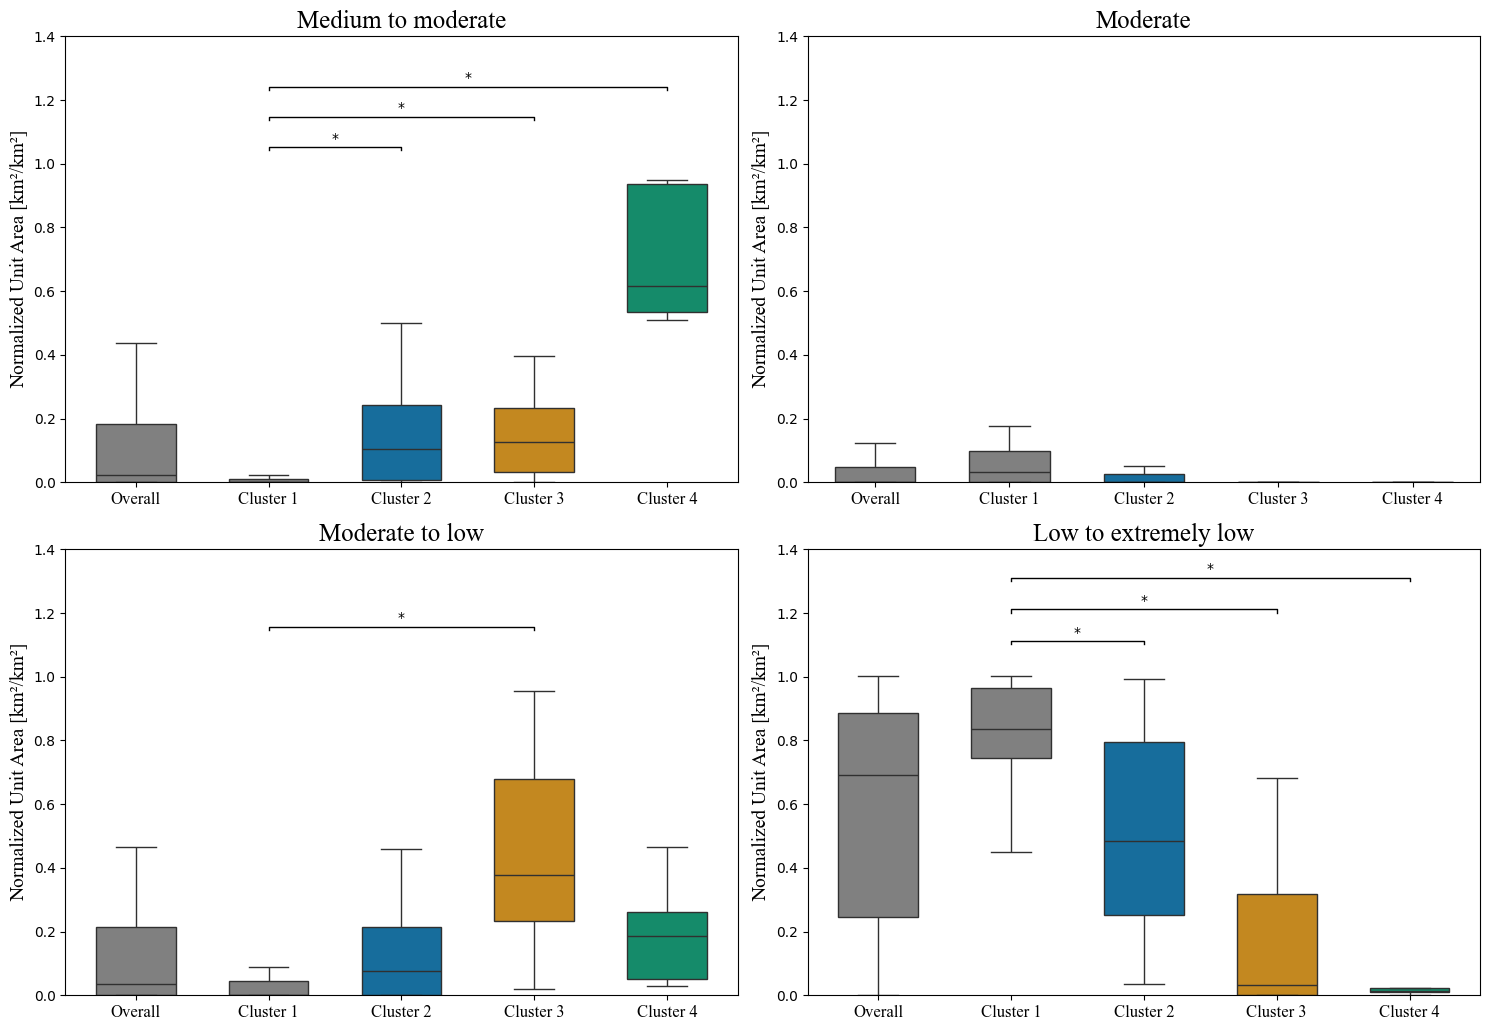

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data from the provided Excel file
file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/2_PCA_normalized_kf_merged_overview.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Define the columns to be considered for plotting
land_use_columns = [
    "Medium to moderate", 
    "Moderate",
    "Moderate to low",
    "Low to extremely low",
]

titles = [
    "Medium to moderate", 
    "Moderate",
    "Moderate to low",
    "Low to extremely low",
]

# Convert relevant columns to numeric values
for col in land_use_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter data for 'ges_ezg'
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']

# Create a color palette for the cluster colors from the Seaborn colorblind palette
colorblind_palette = sns.color_palette("colorblind")
selected_colors = ['grey'] + [colorblind_palette[i] for i in [0, 1, 2, 3]]  # Grey for overall, then Blue, Orange, Green, Red

# Provided statistical results for each category
stat_results = {
    'Medium to moderate': {
        'kruskal_stat': 29.31788394,
        'kruskal_p': 1.92012E-06,
        'dunn': {
            (1, 2): 0.001409685,
            (1, 3): 0.040297697,
            (1, 4): 2.52523E-05,
            (2, 3): 0.100141161,
            (2, 4): 0.265279921,
            (3, 4): 1.000000000,
        }
    },
    'Moderate': {
        'kruskal_stat': None,
        'kruskal_p': None,
        'dunn': {}
    },
    'Moderate to low': {
        'kruskal_stat': 19.59870587,
        'kruskal_p': 0.00020555,
        'dunn': {
            (1, 2): 0.155289341,
            (1, 3): 0.000294016,
            (1, 4): 0.11333443,
            (2, 3): 0.096991627,
            (2, 4): 1.000000000,
            (3, 4): 1.000000000,
        }
    },
    'Low to extremely low': {
        'kruskal_stat': 34.20140252,
        'kruskal_p': 1.79641E-07,
        'dunn': {
            (1, 2): 0.010051429,
            (1, 3): 3.47589E-05,
            (1, 4): 0.000100573,
            (2, 3): 0.152960739,
            (2, 4): 0.095506084,
            (3, 4): 1.000000000,
        }
    },
}

# Function to create boxplots for ges_ezg with significant markers
def create_boxplots_ges_ezg(data, title, filename):
    numeric_data = data[land_use_columns]
    
    # Set the size of the entire figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))  

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numeric column and create boxplots
    for i, col in enumerate(numeric_data.columns):
        # Combine overall data with cluster data for plotting
        overall_data = data.copy()
        overall_data['cluster'] = 'Overall'
        combined_data = pd.concat([overall_data, data])

        # Boxplots for each cluster including overall data
        sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=['grey'] + selected_colors, width=0.6, showfliers=False)
        
        # Set the title of the figure from the column title
        axes[i].set_title(titles[i], fontsize=18, fontname='Times New Roman')
        axes[i].set_ylim(0, 1.4)  # Set the y-axis to a maximum value of 1.4
        axes[i].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=14, fontname='Times New Roman')
        axes[i].set_xlabel('', fontsize=14, fontname='Times New Roman')
        axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')

        # Use provided statistical results
        if col in stat_results:
            kruskal_stat = stat_results[col]['kruskal_stat']
            kruskal_p = stat_results[col]['kruskal_p']
            dunn_results = stat_results[col]['dunn']

            if kruskal_stat is not None:
                print(f'Kruskal-Wallis Test for {col}: Statistic={kruskal_stat}, P-Value={kruskal_p}')

            # Add significance markers from provided Dunn's test results
            y_max = np.max(data[col])
            y_step = y_max * 0.1  # Space between markers
            for idx, ((x1, x2), p_value) in enumerate(dunn_results.items()):
                if p_value < 0.05:
                    y = y_max + y_step * (idx + 1)
                    axes[i].plot([x1, x1, x2, x2], [y, y + y_step * 0.1, y + y_step * 0.1, y], lw=1, c='black')
                    axes[i].text((x1 + x2) * .5, y + y_step * 0.15, "*", ha='center', va='bottom', color='black', fontsize=10)

    # Adjust layout to avoid overlap
    plt.suptitle(title, fontsize=18, fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, format='svg')
    plt.show()

# Define the output path
output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/Abbildungen/'

# Distribution of Land Use Areas for Main Catchments
# Create and display boxplots for ges_ezg
create_boxplots_ges_ezg(ges_ezg_data, '', output_path + 'kf_ges_ezg_significant.svg')


### Fig. Medium und extremly low

extremly low an medium permeability separe with ylim=0.3

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\1670402619.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\1670402619.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\1670402619.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined

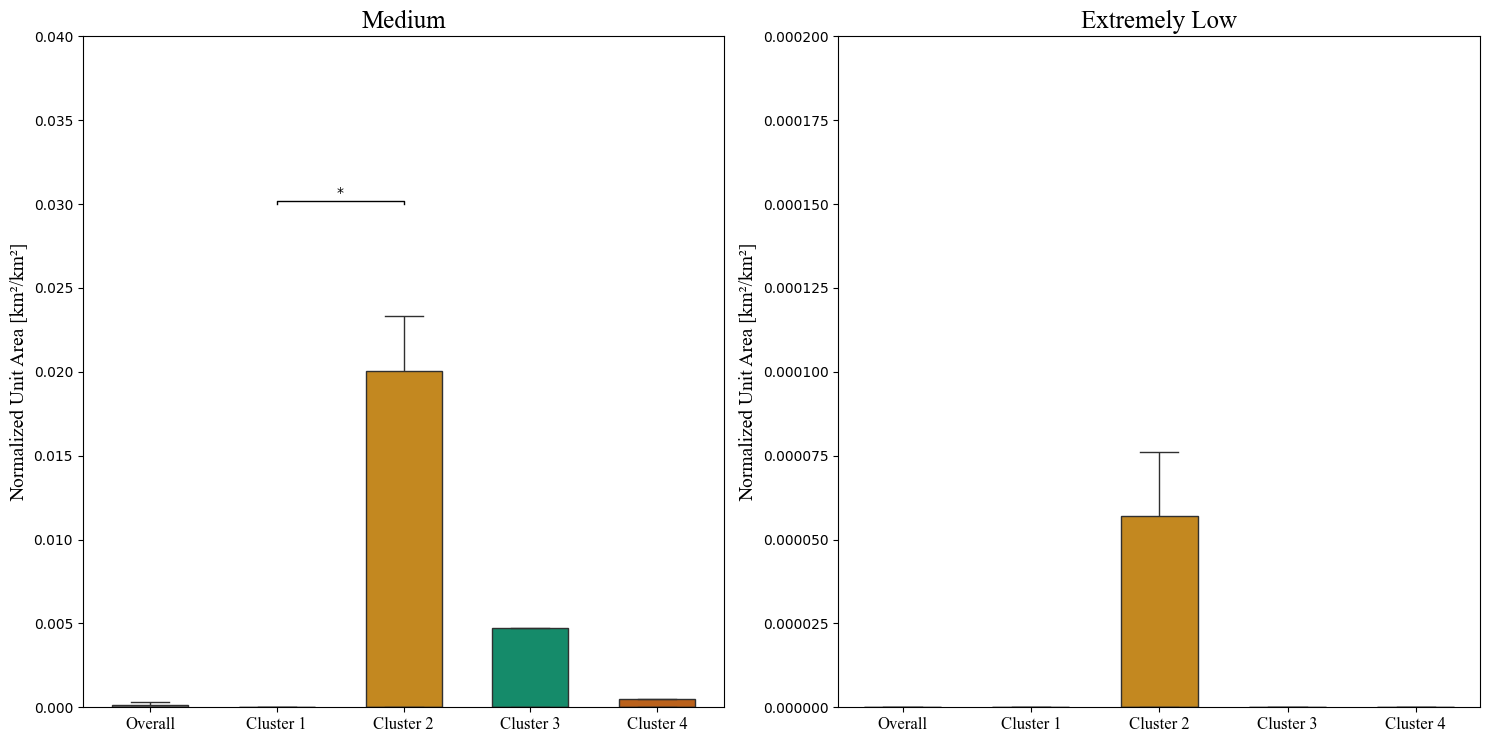

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn

# Load  data 
file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/2_PCA_normalized_kf_merged_overview.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Define columns 
land_use_columns = ["Medium", "Extremely low"]
titles = ["Medium", "Extremely Low"]

#  numeric values
for col in land_use_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']

# Farbpalette 
colorblind_palette = sns.color_palette("colorblind")
selected_colors = ['grey'] + [colorblind_palette[i] for i in [0, 1, 2, 3]]  # Grey for overall, then Blue, Orange, Green, Red

# statistics für Medium
medium_stat_results = {
    'unit': 'Medium',
    'kruskal_stat': 8.608974139,
    'kruskal_p': 0.03496794,
    'dunn': {
        (1, 2): 0.037184377,
        (1, 3): 0.473345504,
    }
}

# Funktion für Boxplots
def create_boxplots_ges_ezg(data, title, filename):
    numeric_data = data[land_use_columns]
    
    # Size
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8)) 

    axes = axes.flatten()

    
    for i, col in enumerate(numeric_data.columns):
        # Overall kreieren
        overall_data = data.copy()
        overall_data['cluster'] = 'Overall'
        combined_data = pd.concat([overall_data, data])

        # Boxplots 
        sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
        
        
        axes[i].set_title(titles[i], fontsize=18, fontname='Times New Roman')
        
        # Set y-axis limits 
        if col == "Medium":
            axes[i].set_ylim(0, 0.04)  # Fixed y-axis limit for Medium
        elif col == "Extremely low":
            axes[i].set_ylim(0, 0.0002)  # Separate y-axis limit for Extremely low
        
        axes[i].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=14, fontname='Times New Roman')
        axes[i].set_xlabel('', fontsize=14, fontname='Times New Roman')
        axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')

        # Stats für Medium
        if col == 'Medium':
            # significance markers 
            for (x1, x2), p_value in medium_stat_results['dunn'].items():
                if p_value < 0.05:
                    y_value = 0.03  # Fixed y-value for the significance markers
                    y_offset = 0.0002  # Fixed offset for the significance lines
                    axes[i].plot([x1, x1, x2, x2], [y_value, y_value + y_offset, y_value + y_offset, y_value], lw=1, c='black')
                    axes[i].text((x1 + x2) * .5, y_value + y_offset * 1.1, "*", ha='center', va='bottom', color='black', fontsize=10)

    
    plt.suptitle(title, fontsize=18, fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, format='svg')
    plt.show()


output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/Abbildungen/'

# Distribution of Permeability Categories for Main Catchments
# boxplots for ges_ezg
create_boxplots_ges_ezg(ges_ezg_data, '', output_path + 'kf_ges_ezg_2_significant.svg')


### Figure Sub-Catchment Significant Permeability Categories

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/PCA_normalized_kf_merged_overview2.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')


land_use_columns = ["Medium to moderate", "Moderate to low", "Low to extremely low"]
titles = ["Medium to moderate", "Moderate to low", "Low to extremely low"]

for col in land_use_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# Normalisierung kontrolle
total_area = data['catch_area']  
for col in land_use_columns:
    data[col] = data[col] / total_area

# Farbpalette
colorblind_palette = sns.color_palette("colorblind")
selected_colors = ['grey'] + [colorblind_palette[i] for i in [0, 1, 2, 3]]  # Grey for overall, then Blue, Orange, Green, Red

# Boxplot mit Significance Markers
def create_boxplots_ges_ezg(data, title, filename):
    numeric_data = data[land_use_columns]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  

    axes = axes.flatten()

    
    for i, col in enumerate(numeric_data.columns):
        # Overall
        overall_data = data.copy()
        overall_data['cluster'] = 'Overall'
        combined_data = pd.concat([overall_data, data])

        # Boxplots 
        sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
        
        
        axes[i].set_title(titles[i], fontsize=18, fontname='Times New Roman')
        axes[i].set_ylim(0, 1.5)  # Set the y-axis limit to 1.5 to reflect normalized data
        axes[i].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=14, fontname='Times New Roman')
        axes[i].set_xlabel('', fontsize=14, fontname='Times New Roman')
        axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')

        
        cluster_groups = [combined_data[col][combined_data['cluster'] == f'Cluster {cluster_num}'].dropna() for cluster_num in range(1, 5)]
        for cluster_num, group in enumerate(cluster_groups, start=1):
            print(f'Cluster {cluster_num} data for {col}: {group.values}')  # Debug output

        # Performing Kruskal-Wallis test
        try:
            kruskal_stat, kruskal_p = stats.kruskal(*cluster_groups)
            print(f'Kruskal-Wallis Test for {col}: Statistic={kruskal_stat}, P-Value={kruskal_p}')
        except ValueError as e:
            print(f'Error performing Kruskal-Wallis test for {col}: {e}')
            continue

        # If significant, perform Dunn's test
        if kruskal_p < 0.05:
            posthoc = posthoc_dunn(combined_data, val_col=col, group_col='cluster', p_adjust='bonferroni')
            print(f'Dunn Test for {col}:\n{posthoc}')
            # Marking significant pairs from Dunn's test
            sig_pairs = []
            clusters = ['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
            for k in range(len(clusters)):
                for j in range(k + 1, len(clusters)):
                    if posthoc.iloc[k, j] < 0.05:
                        sig_pairs.append((k, j, posthoc.iloc[k, j]))

            print(f'Significant pairs for {col}: {sig_pairs}')  # Debug output

            # Add significance markers from Dunn's test
            for idx, (x1, x2, p_value) in enumerate(sig_pairs):
                y_max = combined_data[col].max()
                y_offset = y_max * 0.1 + idx * 0.08  # Increased spacing between markers
                axes[i].plot([x1, x1, x2, x2], [y_max + y_offset, y_max + y_offset * 1.1, y_max + y_offset * 1.1, y_max + y_offset], lw=1, c='black')
                axes[i].text((x1 + x2) * .5, y_max + y_offset * 1.2, "*", ha='center', va='bottom', color='black', fontsize=10)

    # Adjust layout to avoid overlap
    plt.suptitle(title, fontsize=18, fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, format='svg')
    plt.show()

# Define the output path
output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/Abbildungen/'

# Distribution of Permeability Categories for Main Catchments
# Create and display boxplots for ges_ezg
create_boxplots_ges_ezg(ges_ezg_data, '', output_path + 'kf_teil_ezg_significant_normalized.svg')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\1165599557.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\1165599557.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')


Cluster 1 data for Medium to moderate: []
Cluster 2 data for Medium to moderate: []
Cluster 3 data for Medium to moderate: []
Cluster 4 data for Medium to moderate: []
Kruskal-Wallis Test for Medium to moderate: Statistic=nan, P-Value=nan
Cluster 1 data for Moderate to low: []
Cluster 2 data for Moderate to low: []
Cluster 3 data for Moderate to low: []
Cluster 4 data for Moderate to low: []
Kruskal-Wallis Test for Moderate to low: Statistic=nan, P-Value=nan


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\1165599557.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\1165599557.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\1165599557.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_da

Cluster 1 data for Low to extremely low: []
Cluster 2 data for Low to extremely low: []
Cluster 3 data for Low to extremely low: []
Cluster 4 data for Low to extremely low: []
Kruskal-Wallis Test for Low to extremely low: Statistic=nan, P-Value=nan


## 3. Land Use

### NUTZ_LEG Übersetzen + Neue Spalte 


In [50]:
import pandas as pd


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/original.xlsx'


df = pd.read_excel(file_path)

# Übersetzen
translation_dict = {
    'Grünland': 'Grassland',
    'Siedlungsflächen': 'Settlement areas',
    'Wälder': 'Forests',
    'Landwirtschaftliche Flächen heterogener Struktur': 'Agricultural areas of heterogeneous structure',
    'Ackerflächen': 'Arable land',
    'Dauerkulturen': 'Permanent crops',
    'Strauch- und Krautvegetation': 'Shrub and herbaceous vegetation',
    'Unbekannt': 'Unknown'
}

# Neue Spalte mit den übersetzten Kategorien erstellen
df['NUTZ_LEG_EN'] = df['NUTZ_LEG'].map(translation_dict)


output_file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/merged_boden_landnutzung_translated.xlsx'
df.to_excel(output_file_path, index=False)


### Land Use Vorbereitung

In [53]:
import pandas as pd


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung'
excel_data = pd.ExcelFile(file_path)


data = pd.read_excel(file_path, sheet_name='Sheet1')

# Pivot Tabelle
pivot_corrected = data.pivot_table(
    index=['messstelle', 'catch_area'],
    columns='NUTZ_LEG_EN', 
    values='area_2', 
    aggfunc='sum', 
    fill_value=0
)


output_file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/translated_land_use_ezgs.xlsx'
pivot_corrected.to_excel(output_file_path)


print(pivot_corrected.head())


NUTZ_LEG_EN                   Agricultural areas of heterogeneous structure  \
messstelle        catch_area                                                  
abentheuer        39.43                                               0.000   
albisheim         113.18                                              9.229   
alsdorf           99.62                                               1.573   
alsdorf_oberecken 263.81                                              0.000   
altenahr          747.91                                             93.549   

NUTZ_LEG_EN                   Arable land  Forests  Grassland  \
messstelle        catch_area                                    
abentheuer        39.43             0.000   37.666      1.761   
albisheim         113.18           72.472   31.477      0.000   
alsdorf           99.62             0.000   84.007      9.364   
alsdorf_oberecken 263.81           57.778   61.296    140.346   
altenahr          747.91           13.628  465.761    17

### Land Use Merge

In [54]:
import pandas as pd


geologie_file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/translated_land_use_ezgs.xlsx'
merged_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\merged_hierarchie_overview_updated.xlsx'

geologie_data = pd.read_excel(geologie_file_path, sheet_name='Sheet1')
merged_data = pd.read_excel(merged_file_path)

# Anzeigen der ersten Zeilen der Daten zur Überprüfung
print(geologie_data.head())
print(merged_data.head())

# Mergen der Daten anhand der Messstelle
merged_geologie_data = pd.merge(geologie_data, merged_data, how='left', left_on='messstelle', right_on='messstelle')

# Speichern der kombinierten Daten in neue Excel-Datei
output_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\landuse_pruefung\land_use_PCA_merged_overview.xlsx'
merged_geologie_data.to_excel(output_file_path, index=False)

print(f'Die kombinierten Daten wurden erfolgreich gespeichert in {output_file_path}')

          messstelle  catch_area  \
0         abentheuer       39.43   
1          albisheim      113.18   
2            alsdorf       99.62   
3  alsdorf_oberecken      263.81   
4           altenahr      747.91   

   Agricultural areas of heterogeneous structure  Arable land  Forests  \
0                                          0.000        0.000   37.666   
1                                          9.229       72.472   31.477   
2                                          1.573        0.000   84.007   
3                                          0.000       57.778   61.296   
4                                         93.549       13.628  465.761   

   Grassland  Permanent crops  Settlement areas  \
0      1.761              0.0             0.000   
1      0.000              0.0             0.000   
2      9.364              0.0             4.678   
3    140.346              0.0             4.387   
4    174.976              0.0             0.000   

   Shrub and herbaceous vegetat

Normalize Areas

In [59]:
import pandas as pd


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/land_use_PCA_merged_overview.xlsx'
data = pd.read_excel(file_path)

# List of columns to normalize
land_use_columns = [
    'Agricultural areas of heterogeneous structure', 
    'Arable land', 
    'Forests', 
    'Grassland', 
    'Permanent crops', 
    'Settlement areas', 
    'Shrub and herbaceous vegetation', 
    'Unknown'
]


for col in land_use_columns:
    data[col] = data[col] / data['catch_area']

# Save 
output_file_path_normalized = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/normalized_land_use_by_messstelle.xlsx'
data.to_excel(output_file_path_normalized, index=False)

print("Normalized data saved to", output_file_path_normalized)


Normalized data saved to C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/normalized_land_use_by_messstelle.xlsx


### Distributions Land Use

In [53]:
import pandas as pd


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/normalized_land_use_by_messstelle.xlsx'
data = pd.read_excel(file_path)

# Filter 
categories = [
     'Agricultural areas of heterogeneous structure', 'Arable land', 'Forests',
    'Grassland', 'Permanent crops', 'Settlement areas', 
    'Shrub and herbaceous vegetation'
]


for col in categories:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# Normalisieren 
ges_ezg_summed = ges_ezg_data.groupby('cluster')[categories].sum()
teil_ezg_summed = teil_ezg_data.groupby('cluster')[categories].sum()

# Overall Kategorie
ges_ezg_summed.loc['Overall'] = ges_ezg_summed.sum()
teil_ezg_summed.loc['Overall'] = teil_ezg_summed.sum()

# Overall zuerst
ges_ezg_summed = ges_ezg_summed.loc[['Overall'] + sorted([i for i in ges_ezg_summed.index if isinstance(i, int)])]
teil_ezg_summed = teil_ezg_summed.loc[['Overall'] + sorted([i for i in teil_ezg_summed.index if isinstance(i, int)])]


ges_ezg_summed = ges_ezg_summed.div(ges_ezg_summed.sum(axis=1), axis=0)
teil_ezg_summed = teil_ezg_summed.div(teil_ezg_summed.sum(axis=1), axis=0)


output = pd.DataFrame({
    'Kategorie': categories,
    'ges_ezg': ges_ezg_summed.loc['Overall'] * 100,
    'teil_ezg': teil_ezg_summed.loc['Overall'] * 100
})

# Merge mit cluster data
for cluster in ges_ezg_summed.index:
    if cluster != 'Overall':
        output[f'ges_ezg_cluster_{cluster}'] = ges_ezg_summed.loc[cluster] * 100
        output[f'teil_ezg_cluster_{cluster}'] = teil_ezg_summed.loc[cluster] * 100

# Save
output.to_excel('C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/Appendix/land_use_distribution.xlsx', index=False)
print("File saved as 'land_use_distribution.xlsx'")

File saved as 'land_use_distribution.xlsx'


### Land Use Distribution Figure

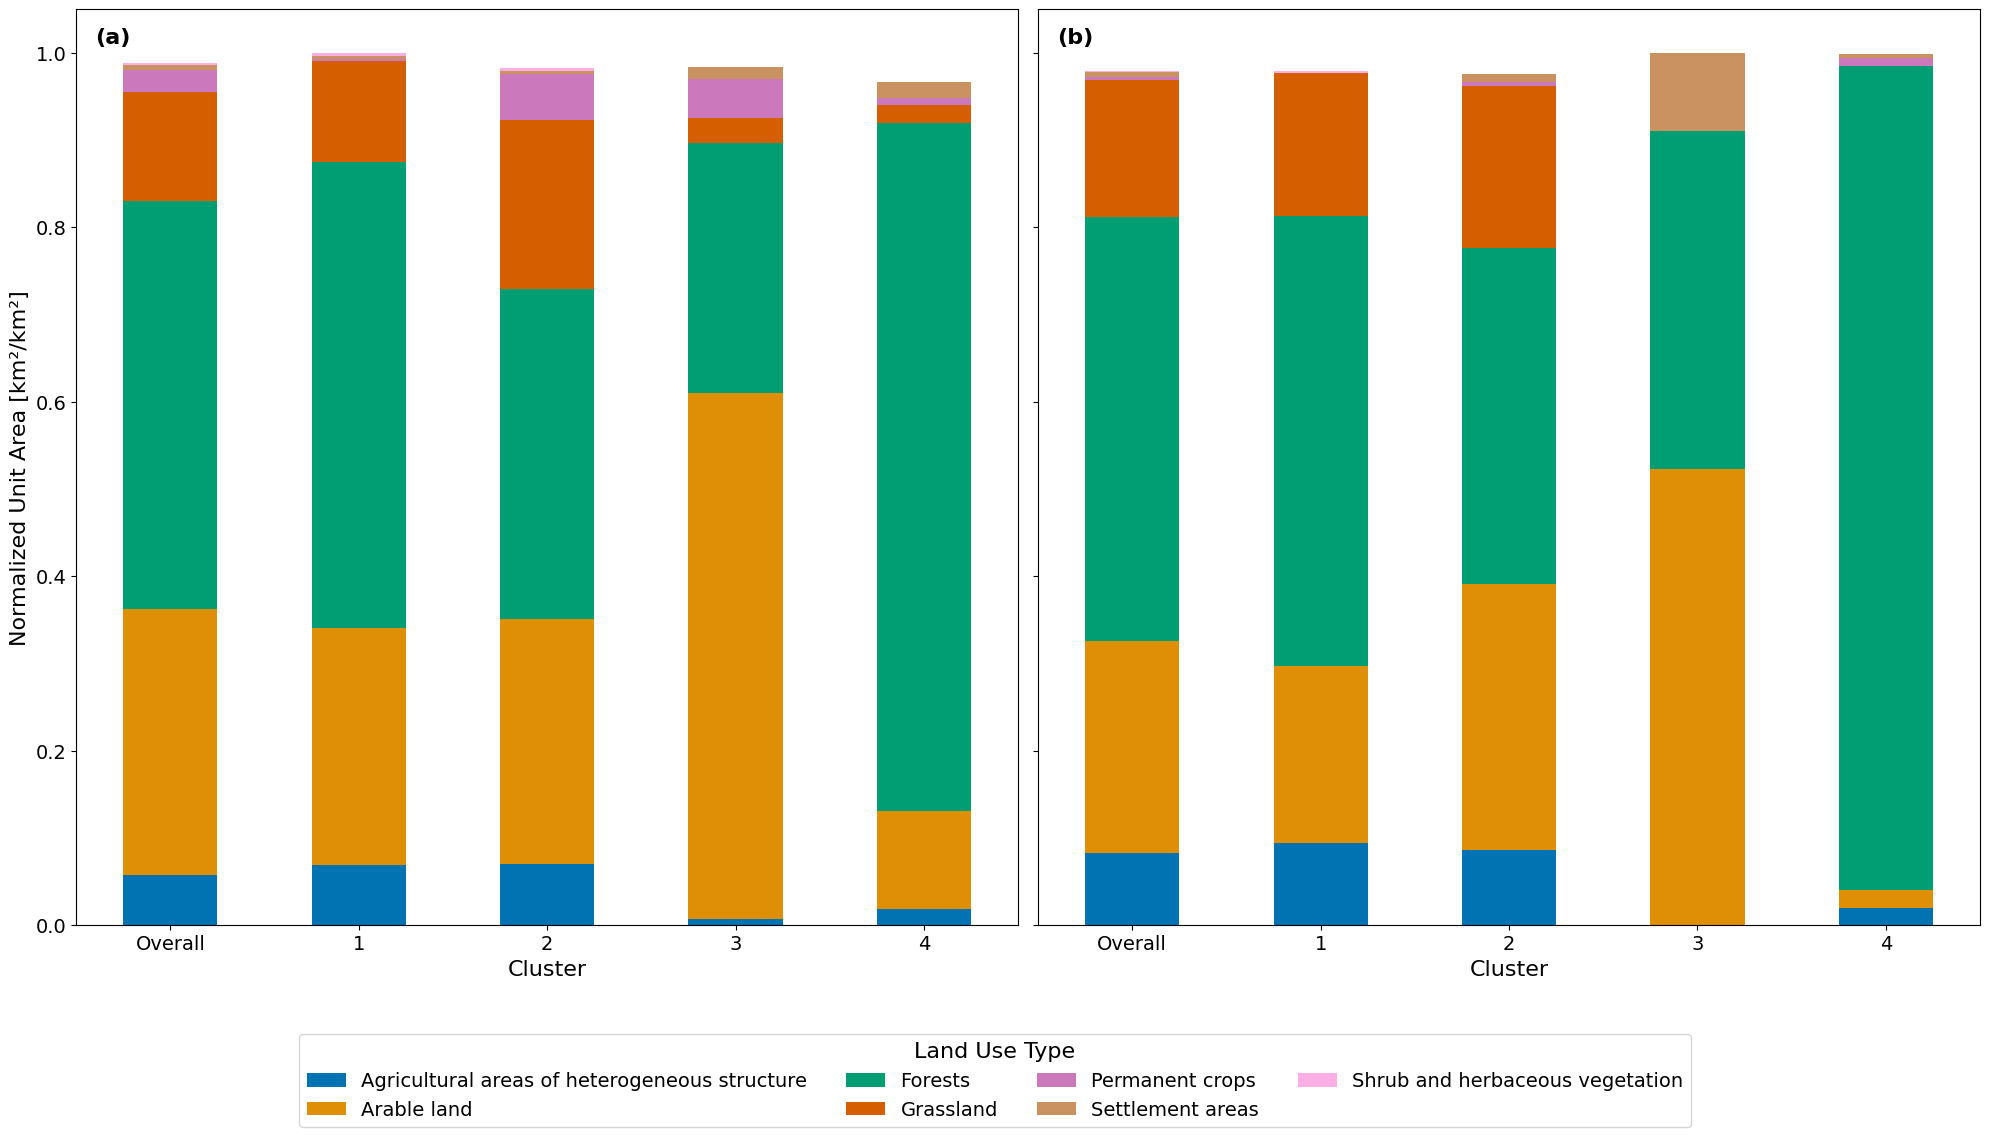

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/normalized_land_use_by_messstelle.xlsx'
data = pd.read_excel(file_path)

# Define the land use columns and clusters
land_use_columns = [
    'Agricultural areas of heterogeneous structure', 'Arable land', 'Forests',
    'Grassland', 'Permanent crops', 'Settlement areas', 
    'Shrub and herbaceous vegetation'
]

# Prepare data for ges_ezg and teil_ezg based on ezg_id
data_ges_ezg = data[data['ezg_id'] == 'ges_ezg']
data_teil_ezg = data[data['ezg_id'] == 'teil_ezg']

# Calculate means for each category
cluster_means_ges_ezg = data_ges_ezg.groupby('cluster')[land_use_columns].mean()
cluster_means_teil_ezg = data_teil_ezg.groupby('cluster')[land_use_columns].mean()

# Calculate overall means
overall_mean_ges_ezg = data_ges_ezg[land_use_columns].mean().to_frame().T
overall_mean_ges_ezg.index = ['Overall']
overall_mean_teil_ezg = data_teil_ezg[land_use_columns].mean().to_frame().T
overall_mean_teil_ezg.index = ['Overall']

# Combine overall means and cluster means
combined_means_ges_ezg = pd.concat([overall_mean_ges_ezg, cluster_means_ges_ezg])
combined_means_teil_ezg = pd.concat([overall_mean_teil_ezg, cluster_means_teil_ezg])

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)

# Plot for ges_ezg
combined_means_ges_ezg.plot(kind='bar', stacked=True, ax=axes[0], color=sns.color_palette("colorblind", len(land_use_columns)))
axes[0].set_title('', fontsize=18)
axes[0].set_xlabel('Cluster', fontsize=16)
axes[0].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=16)
axes[0].tick_params(axis='x', labelrotation=0, labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].text(0.02, 0.98, '(a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
axes[0].get_legend().remove()  # Remove legend from the subplot

# Plot for teil_ezg
combined_means_teil_ezg.plot(kind='bar', stacked=True, ax=axes[1], color=sns.color_palette("colorblind", len(land_use_columns)))
axes[1].set_title('', fontsize=18)
axes[1].set_xlabel('Cluster', fontsize=16)
axes[1].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=16)
axes[1].tick_params(axis='x', labelrotation=0, labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].text(0.02, 0.98, '(b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
axes[1].get_legend().remove()  # Remove legend from the subplot

# Common legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title='Land Use Type', title_fontsize=16, fontsize=14, bbox_to_anchor=(0.5, -0.03), loc='upper center', ncol=4)

plt.tight_layout()

# Save the figure as an SVG file
output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/land_use_distribution.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight')

plt.show()


### Fig. Landuse Boxplots

Mit Overall

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\2246013385.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\2246013385.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\2246013385.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combine

Kruskal-Wallis Test for Agricultural areas of heterogeneous structure: Statistic=9.02264745, P-Value=0.028991287


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\2246013385.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\2246013385.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\2246013385.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=

Kruskal-Wallis Test for Arable land: Statistic=11.37571848, P-Value=0.00985841
Kruskal-Wallis Test for Forests: Statistic=18.6009431, P-Value=0.000330573


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\2246013385.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')


Kruskal-Wallis Test for Grassland: Statistic=8.676423874, P-Value=0.033917207


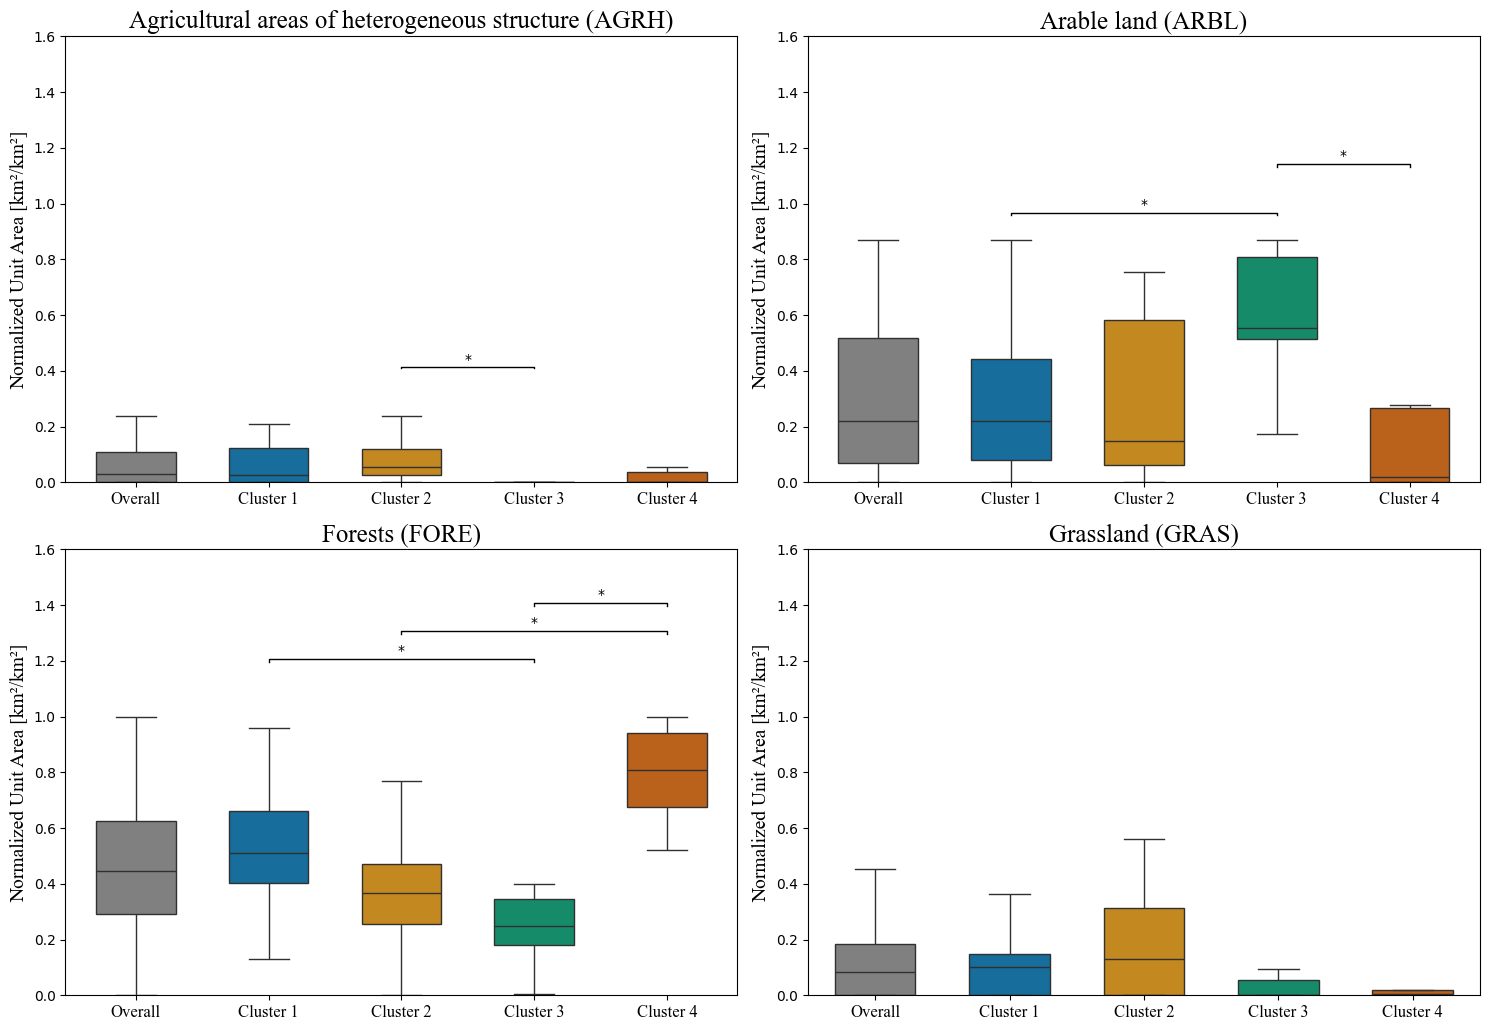

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/normalized_land_use_by_messstelle.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')


land_use_columns = [
    "Agricultural areas of heterogeneous structure", 
    "Arable land",
    "Forests",
    "Grassland",
]

titles = [
    "Agricultural areas of heterogeneous structure (AGRH)", 
    "Arable land (ARBL)",
    "Forests (FORE)",
    "Grassland (GRAS)",
]


for col in land_use_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']

# Farbpalette
colorblind_palette = sns.color_palette("colorblind")
selected_colors = ['grey'] + [colorblind_palette[i] for i in [0, 1, 2, 3]]  # Grey for overall, then Blue, Orange, Green, Red

# Provided statistical results 
stat_results = {
    'Agricultural areas of heterogeneous structure': {
        'kruskal_stat': 9.02264745,
        'kruskal_p': 0.028991287,
        'dunn': {
            (1, 3): 0.154067564,
            (2, 3): 0.040100217,
            (2, 4): 0.515686082,
        }
    },
    'Arable land': {
        'kruskal_stat': 11.37571848,
        'kruskal_p': 0.00985841,
        'dunn': {
            (1, 3): 0.035279582,
            (2, 3): 0.059924978,
            (3, 4): 0.011263409,
        }
    },
    'Forests': {
        'kruskal_stat': 18.6009431,
        'kruskal_p': 0.000330573,
        'dunn': {
            (1, 2): 0.09513454,
            (1, 3): 0.033109177,
            (2, 4): 0.006818258,
            (3, 4): 0.002107773,
        }
    },
    'Grassland': {
        'kruskal_stat': 8.676423874,
        'kruskal_p': 0.033917207,
        'dunn': {
            (2, 3): 0.072180801,
            (2, 4): 0.296686477,
        }
    },
}

# Boxplots für ges_ezg
def create_boxplots_ges_ezg(data, title, filename):
    numeric_data = data[land_use_columns]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))  
    axes = axes.flatten()

    
    for i, col in enumerate(numeric_data.columns):
        # Combine overall data with clusters
        overall_data = data.copy()
        overall_data['cluster'] = 'Overall'
        combined_data = pd.concat([overall_data, data])

        # Boxplots
        sns.boxplot(x='cluster', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
        
        
        axes[i].set_title(titles[i], fontsize=18, fontname='Times New Roman')
        axes[i].set_ylim(0, 1.6)  # Set the y-axis to a maximum value of 1.4
        axes[i].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=14, fontname='Times New Roman')
        axes[i].set_xlabel('', fontsize=14, fontname='Times New Roman')
        axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')

        #Nutze stat info
        if col in stat_results:
            kruskal_stat = stat_results[col]['kruskal_stat']
            kruskal_p = stat_results[col]['kruskal_p']
            dunn_results = stat_results[col]['dunn']

            if kruskal_stat is not None:
                print(f'Kruskal-Wallis Test for {col}: Statistic={kruskal_stat}, P-Value={kruskal_p}')

            # Signifikanz Markers
            y_max = np.max(data[col])
            y_step = y_max * 0.1  # Space between markers
            for idx, ((x1, x2), p_value) in enumerate(dunn_results.items()):
                if p_value < 0.05:
                    y = y_max + y_step * (idx + 1)
                    axes[i].plot([x1, x1, x2, x2], [y, y + y_step * 0.1, y + y_step * 0.1, y], lw=1, c='black')
                    axes[i].text((x1 + x2) * .5, y + y_step * 0.15, "*", ha='center', va='bottom', color='black', fontsize=10)

    
    plt.suptitle(title, fontsize=18, fontname='Times New Roman')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, format='svg')
    plt.show()

# output path
output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/Abbildungen/'

# Distribution of Land Use Areas for Main Catchments
# Create and display boxplots for ges_ezg
create_boxplots_ges_ezg(ges_ezg_data, '', output_path + 'landuse_significant.svg')



### LANDUSE STATISTICS 

In [82]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/PCA_landuse.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')


land_use_categories = {
    'AGRH': 'Agricultural areas of heterogeneous structure',
    'ARBL': 'Arable land',
    'FORE': 'Forests',
    'GRAS': 'Grassland',
    'PERM': 'Permanent crops',
    'SETT': 'Settlement areas',
    'SHVE': 'Shrub and herbaceous vegetation',
    'UNKN_LU': 'Unknown'
}


for col in land_use_categories.keys():
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# Funktion für statistical tests
def perform_statistical_tests(data):
    numeric_data = data[list(land_use_categories.keys())]
    clusters = data['cluster']
    results = []
    
    for col in numeric_data.columns:
        unit = col
        cluster_groups = [numeric_data[col][clusters == cluster_num].dropna() for cluster_num in range(1, 5)]
        
        # Kruskal-Wallis Test
        kruskal_result = stats.kruskal(*cluster_groups)
        result = {
            'Unit': unit,
            'Test': 'Kruskal-Wallis',
            'Statistic': kruskal_result.statistic,
            'P-Value': kruskal_result.pvalue,
            'Note': 'Significant differences' if kruskal_result.pvalue < 0.05 else 'Insufficient variance'
        }
        results.append(pd.DataFrame([result]))
        
        if kruskal_result.pvalue < 0.05:  # Only if Kruskal-Wallis is significant, perform post-hoc test
            dunn_result = sp.posthoc_dunn(cluster_groups, p_adjust='bonferroni')
            dunn_result = dunn_result.melt(var_name='Comparison', value_name='P-Value')
            dunn_result['Test'] = 'Dunn'
            dunn_result['Unit'] = unit
            results.append(dunn_result)

            # Mann-Whitney-U-Tests
            for i in range(len(cluster_groups)):
                for j in range(i + 1, len(cluster_groups)):
                    if len(cluster_groups[i]) > 0 and len(cluster_groups[j]) > 0:
                        mannwhitney_result = stats.mannwhitneyu(cluster_groups[i], cluster_groups[j])
                        result = {
                            'Unit': unit,
                            'Test': f'Mann-Whitney {i+1} vs {j+1}',
                            'Statistic': mannwhitney_result.statistic,
                            'P-Value': mannwhitney_result.pvalue
                        }
                        results.append(pd.DataFrame([result]))
    
    return pd.concat(results)

# Perform tests for 'ges_ezg' and 'teil_ezg'
ges_ezg_results = perform_statistical_tests(ges_ezg_data)
teil_ezg_results = perform_statistical_tests(teil_ezg_data)

# Save 
ges_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/land_use_normalized_ges_ezg_stats_results.xlsx'
teil_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/land_use_normalized_teil_ezg_stats_results.xlsx'

ges_ezg_results.to_excel(ges_ezg_results_path, index=False)
teil_ezg_results.to_excel(teil_ezg_results_path, index=False)

print("Results for 'ges_ezg' saved to:", ges_ezg_results_path)
print("Results for 'teil_ezg' saved to:", teil_ezg_results_path)


Results for 'ges_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/land_use_normalized_ges_ezg_stats_results.xlsx
Results for 'teil_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/landuse_pruefung/land_use_normalized_teil_ezg_stats_results.xlsx


## 4. Soil Characteristics

### Soil Vorbereitung

In [ ]:
import pandas as pd

# Load Excel
file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/soil_land_use/merged_boden_landnutzung_translated.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the data from the first sheet
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Create the pivot table with 'messstelle' as the index 
pivot_corrected = data.pivot_table(
    index='messstelle', 
    columns='BGL_LEG_EN', 
    values='area_2', 
    aggfunc='sum', 
    fill_value=0
)

# Save the pivot table (Excel 
pivot_corrected.to_excel('C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/soil_land_use/soil_sums_ezgs.xlsx')

# Display the first few rows of the corrected pivot table
print(pivot_corrected.head())

### Soil Merge

In [ ]:
import pandas as pd


geologie_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\soil_land_use\soil_sums_ezgs.xlsx'
merged_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\merged_hierarchie_overview_updated.xlsx'

# Lesen der Daten
geologie_data = pd.read_excel(geologie_file_path, sheet_name='Sheet1')
merged_data = pd.read_excel(merged_file_path)

# Anzeigen  zur Überprüfung
print(geologie_data.head())
print(merged_data.head())

# Mergen anhand der Messstellen
merged_geologie_data = pd.merge(geologie_data, merged_data, how='left', left_on='messstelle', right_on='messstelle')

# Speichern der kombinierten Daten in  Excel-Datei
output_file_path = r'C:\Users\Lenovo\Documents\Masterarbeit\Masterarbeit\3_arbeitsordner\soil_land_use\soils_PCA_merged_overview.xlsx'
merged_geologie_data.to_excel(output_file_path, index=False)

print(f'Die kombinierten Daten wurden erfolgreich gespeichert in {output_file_path}')

### Distributions Berrechnung

In [50]:
import pandas as pd


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils.xlsx'
data = pd.read_excel(file_path)

# Filter
categories = [
    'CARB',
    'SSCL',
    'SILI',
    'VOLC',
    'QGSC',
    'CLAY',
    'FLDP',
    'LOES',
    'OLDR',
    'UNKN']


for col in categories:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# Sum the normalized values for each soil category and each cluster
ges_ezg_summed = ges_ezg_data.groupby('cluster')[categories].sum()
teil_ezg_summed = teil_ezg_data.groupby('cluster')[categories].sum()

# Add Overall kategorie
ges_ezg_summed.loc['Overall'] = ges_ezg_summed.sum()
teil_ezg_summed.loc['Overall'] = teil_ezg_summed.sum()

# Overall zuerst
ges_ezg_summed = ges_ezg_summed.loc[['Overall'] + sorted([i for i in ges_ezg_summed.index if isinstance(i, int)])]
teil_ezg_summed = teil_ezg_summed.loc[['Overall'] + sorted([i for i in teil_ezg_summed.index if isinstance(i, int)])]

# Normalize
ges_ezg_summed = ges_ezg_summed.div(ges_ezg_summed.sum(axis=1), axis=0)
teil_ezg_summed = teil_ezg_summed.div(teil_ezg_summed.sum(axis=1), axis=0)

# Prepare a DataFrame for the output
output = pd.DataFrame({
    'Kategorie': categories,
    'ges_ezg': ges_ezg_summed.loc['Overall'] * 100,
    'teil_ezg': teil_ezg_summed.loc['Overall'] * 100
})

# Merge with cluster data
for cluster in ges_ezg_summed.index:
    if cluster != 'Overall':
        output[f'ges_ezg_cluster_{cluster}'] = ges_ezg_summed.loc[cluster] * 100
        output[f'teil_ezg_cluster_{cluster}'] = teil_ezg_summed.loc[cluster] * 100

# Save 
output.to_excel('C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils_distribution.xlsx', index=False)
print("File saved as 'soils_distribution.xlsx'")

File saved as 'soils_distribution.xlsx'


### SOILS STATISTICS

In [184]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/2_PCA_normalized_soils_merged_overview.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')

# Define soil categories
soil_categories = {
    'CARB': 'Soils of areas with a high proportion of carbonate rocks alternating with loess',
    'SSCL': 'Soils of areas with a high proportion of sand, silt and clay rocks',
    'SILI': 'Soils of areas with a high proportion of silicate rocks alternating with loess',
    'VOLC': 'Soils of areas with basic to intermediate volcanic rocks, partly alternating with loess loam',
    'QGSC': 'Soils of areas with high proportions of quartzites, greywackes, sandstones and conglomerates as well as clay and silt shales',
    'CLAY': 'Soils of the clay and silt shale areas with varying proportions of greywacke, limestone, sandstone and quartzite; partly mixed with loess loam',
    'FLDP': 'Soils of the floodplains and lower terraces (including associated moors and drift sand areas)',
    'LOES': 'Soils of the loess landscapes of the highlands (basins, valley widenings, depressions, highland slopes and loess hill lands)',
    'OLDR': 'Soils of the older river terraces',
    'UNKN': 'Unknown soils'
}


# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']

# Funktion für statistische tests
def perform_statistical_tests(data):
    numeric_data = data[list(soil_categories.keys())]
    clusters = data['cluster']
    results = []
    
    for col in numeric_data.columns:
        unit = col
        cluster_groups = [numeric_data[col][clusters == cluster_num].dropna() for cluster_num in range(1, 5)]
        
        # Check for variability in cluster groups
        if all(group.nunique() > 1 for group in cluster_groups if len(group) > 0):
            # Kruskal-Wallis Test
            kruskal_result = stats.kruskal(*cluster_groups)
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': kruskal_result.statistic,
                'P-Value': kruskal_result.pvalue,
                'Note': 'Significant differences' if kruskal_result.pvalue < 0.05 else 'Insufficient variance'
            }
            results.append(pd.DataFrame([result]))
            
            if kruskal_result.pvalue < 0.05:  
                dunn_result = sp.posthoc_dunn(cluster_groups, p_adjust='bonferroni')
                dunn_result = dunn_result.melt(var_name='Comparison', value_name='P-Value')
                dunn_result['Test'] = 'Dunn'
                dunn_result['Unit'] = unit
                results.append(dunn_result)
        else:
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': 'N/A',
                'P-Value': 'N/A',
                'Note': 'Insufficient variance'
            }
            results.append(pd.DataFrame([result]))

    return pd.concat(results)


ges_ezg_results = perform_statistical_tests(ges_ezg_data)
teil_ezg_results = perform_statistical_tests(teil_ezg_data)

# Save 
ges_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils_stats_ges_ezg.xlsx'
teil_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils_stats_teil_ezg.xlsx'

ges_ezg_results.to_excel(ges_ezg_results_path, index=False)
teil_ezg_results.to_excel(teil_ezg_results_path, index=False)

print("Results for 'ges_ezg' saved to:", ges_ezg_results_path)
print("Results for 'teil_ezg' saved to:", teil_ezg_results_path)


Results for 'ges_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils_normalized_ges_ezg_stats_results.xlsx
Results for 'teil_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils_normalized_teil_ezg_stats_results.xlsx


### Fig Soils Overview

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils.xlsx'
data = pd.read_excel(file_path)


categories = [
    'CARB',
    'SSCL',
    'SILI',
    'VOLC',
    'QGSC',
    'CLAY',
    'FLDP',
    'LOES',
    'OLDR',
    'UNKN']


for col in categories:
    data[col] = pd.to_numeric(data[col], errors='coerce')


def create_stacked_bar_plots(data, filename):
    # Filter for ges_ezg und teil_ezg
    ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
    teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']
    
    
    ges_ezg_summed = ges_ezg_data.groupby('cluster')[categories].sum()
    teil_ezg_summed = teil_ezg_data.groupby('cluster')[categories].sum()
    
    # Add an "Overall" category 
    ges_ezg_summed.loc['Overall'] = ges_ezg_summed.sum()
    teil_ezg_summed.loc['Overall'] = teil_ezg_summed.sum()
    
    # Overall zuerst
    ges_ezg_summed = ges_ezg_summed.loc[['Overall'] + sorted([i for i in ges_ezg_summed.index if isinstance(i, int)])]
    teil_ezg_summed = teil_ezg_summed.loc[['Overall'] + sorted([i for i in teil_ezg_summed.index if isinstance(i, int)])]
    
    ges_ezg_summed = ges_ezg_summed.div(ges_ezg_summed.sum(axis=1), axis=0)
    teil_ezg_summed = teil_ezg_summed.div(teil_ezg_summed.sum(axis=1), axis=0)
    
    indices_ges = ges_ezg_summed.index.astype(str)
    indices_teil = teil_ezg_summed.index.astype(str)
    
    colorblind_palette = sns.color_palette("colorblind", len(categories))
    
    # Plot 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
    
    width = 0.35  # Width of the bars

    # Plot for ges_ezg
    bottom = None
    for i, col in enumerate(categories):
        if i == 0:
            bottom = ges_ezg_summed[col]
            ax1.bar(indices_ges, ges_ezg_summed[col], width=width, label=col, color=colorblind_palette[i])
        else:
            ax1.bar(indices_ges, ges_ezg_summed[col], width=width, bottom=bottom, label=col, color=colorblind_palette[i])
            bottom += ges_ezg_summed[col]
    
    ax1.set_xlabel('Cluster', fontsize=14, fontname='Times New Roman')
    ax1.set_ylabel('Normalized Unit Area [km²/km²]', fontsize=16, fontname='Times New Roman')
    ax1.text(0.03, 0.98, '(a)', transform=ax1.transAxes, fontsize=16, fontname='Times New Roman', va='top', ha='right')
    ax1.set_xticks(range(len(indices_ges)))
    ax1.set_xticklabels(indices_ges, fontsize=14, fontname='Times New Roman')

    # Plot for teil_ezg
    bottom = None
    for i, col in enumerate(categories):
        if i == 0:
            bottom = teil_ezg_summed[col]
            ax2.bar(indices_teil, teil_ezg_summed[col], width=width, label=col, color=colorblind_palette[i])
        else:
            ax2.bar(indices_teil, teil_ezg_summed[col], width=width, bottom=bottom, label=col, color=colorblind_palette[i])
            bottom += teil_ezg_summed[col]
    
    ax2.set_xlabel('Cluster', fontsize=16, fontname='Times New Roman')
    ax2.text(0.03, 0.98, '(b)', transform=ax2.transAxes, fontsize=16, fontname='Times New Roman', va='top', ha='right')
    ax2.set_xticks(range(len(indices_teil)))
    ax2.set_xticklabels(indices_teil, fontsize=14, fontname='Times New Roman')

    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=14, title='Soil Category', title_fontsize=16, bbox_to_anchor=(0.5, -0.1))
    
    plt.tight_layout()
    
    # Save 
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.show()


create_stacked_bar_plots(data, 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils_overview.svg')

### Fig Soils Significant

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\3969515186.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_combined', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\3969515186.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8256\3969515186.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_combined', y=col

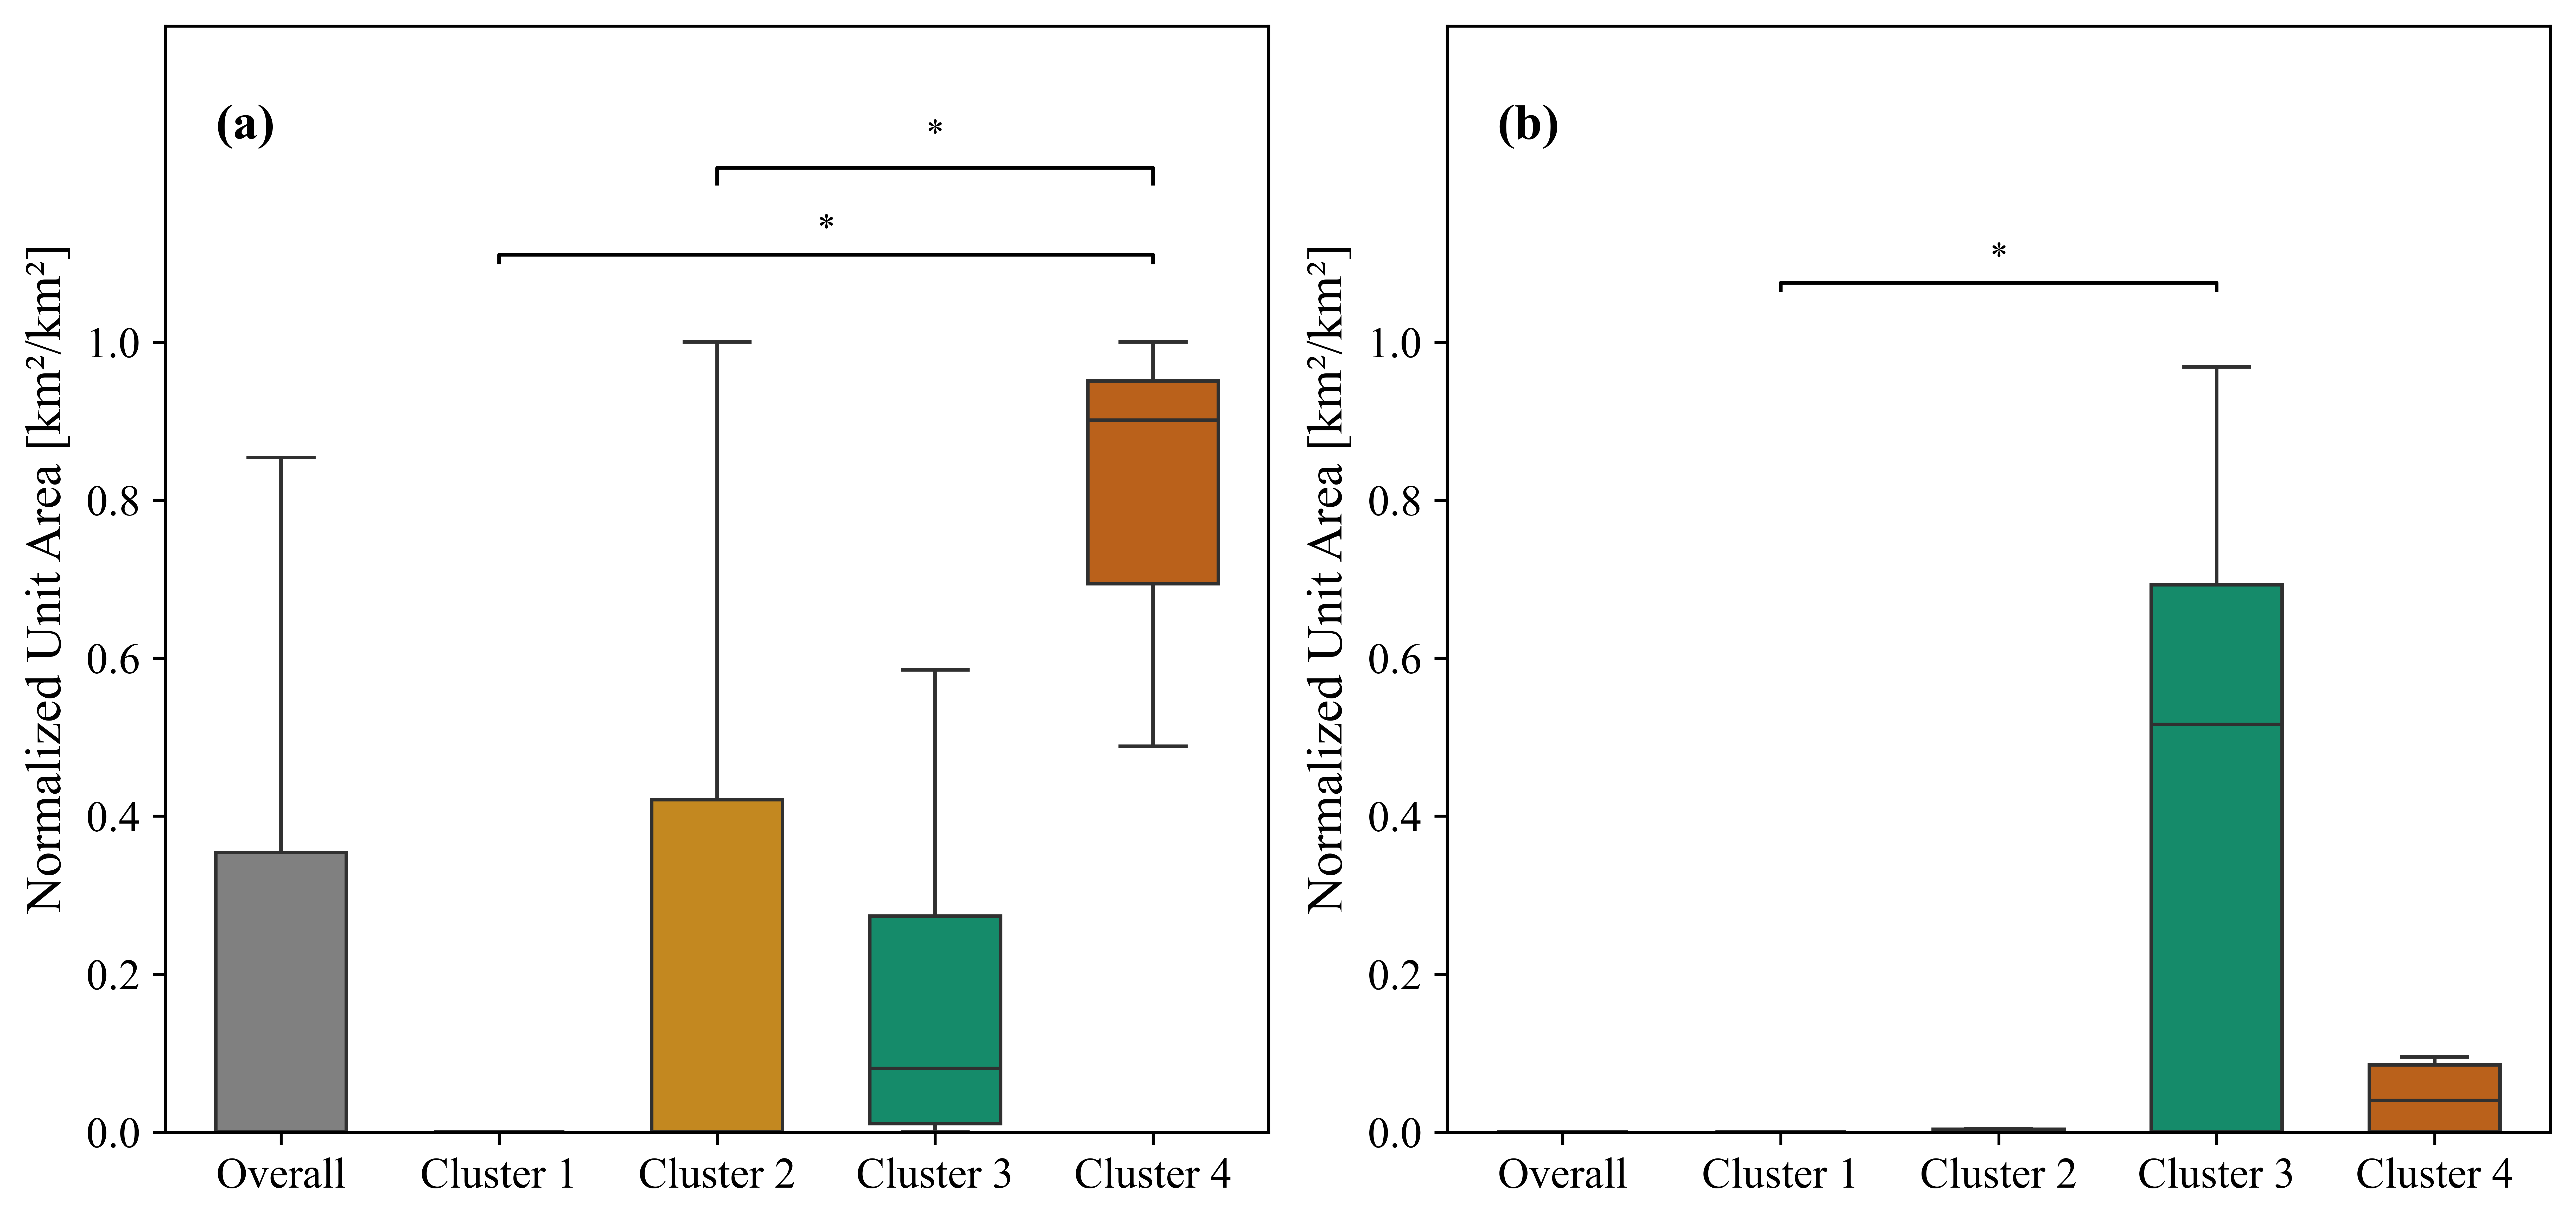

In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/soils.xlsx'
data = pd.read_excel(file_path, sheet_name='Tabelle1')
land_use_columns = ['SSCL', 'LOES']
data[land_use_columns] = data[land_use_columns].apply(pd.to_numeric, errors='coerce')
columns = ['SSCL', 'LOES']

# farbpalette
colorblind_palette = sns.color_palette("colorblind")
selected_colors = ['grey'] + [colorblind_palette[i] for i in [0, 1, 2, 3]]  # Grey for overall, then blue, orange, green, red

# Function mit significant markers
def create_boxplots(data, filename):
    # Set the size of the entire figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes = axes.flatten()

    for i, col in enumerate(columns):
        
        overall_data = data.copy()
        overall_data['cluster_combined'] = 'Overall'
        combined_data = pd.concat([overall_data, data.assign(cluster_combined=data['cluster'].astype(str).replace({'1': 'Cluster 1', '2': 'Cluster 2', '3': 'Cluster 3', '4': 'Cluster 4'}))])

        # Boxplots
        sns.boxplot(x='cluster_combined', y=col, data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
        
        
        axes[i].text(-0.3, 1.3, '(a)' if i == 0 else '(b)', fontsize=14, fontweight='bold', va='top', ha='left')
        
        axes[i].set_ylim(0, 1.4)  # Set the y-axis to a maximum value of 1.5
        axes[i].set_ylabel('Normalized Unit Area [km²/km²]', fontsize=14, fontname='Times New Roman')
        axes[i].set_xlabel('', fontsize=14, fontname='Times New Roman')
        axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')

        # Set y-ticks
        yticks = axes[i].get_yticks()
        new_yticks = [tick for tick in yticks if tick <= 1.0]
        axes[i].set_yticks(new_yticks)

        # If significant, perform Dunn's test and mark significant pairs
        significant_pairs = {
            'SSCL': [(1, 4), (2, 4)],
            'LOES': [(1, 3)]
        }

        sig_pairs = significant_pairs[col]

        # Add significance markers from Dunn's test
        for idx, (x1, x2) in enumerate(sig_pairs):
            y_max = np.max(data[col])
            y_offset = y_max * 0.1 + idx * 0.1  # Increased spacing between markers
            axes[i].plot([x1, x1, x2, x2], [y_max + y_offset, y_max + y_offset * 1.1, y_max + y_offset * 1.1, y_max + y_offset], lw=1, c='black')
            axes[i].text((x1 + x2) * .5, y_max + y_offset * 1.2, "*", ha='center', va='bottom', color='black', fontsize=10)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, format='svg')
    plt.show()

# Define the output path
output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/Abbildungen/'

# Create and display boxplots
create_boxplots(data, output_path + 'soils_significant_ges_ezg.svg')



## 5. Elevation

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\912330775.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_combined', y='mean', data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\912330775.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20192\912330775.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_combined', y=

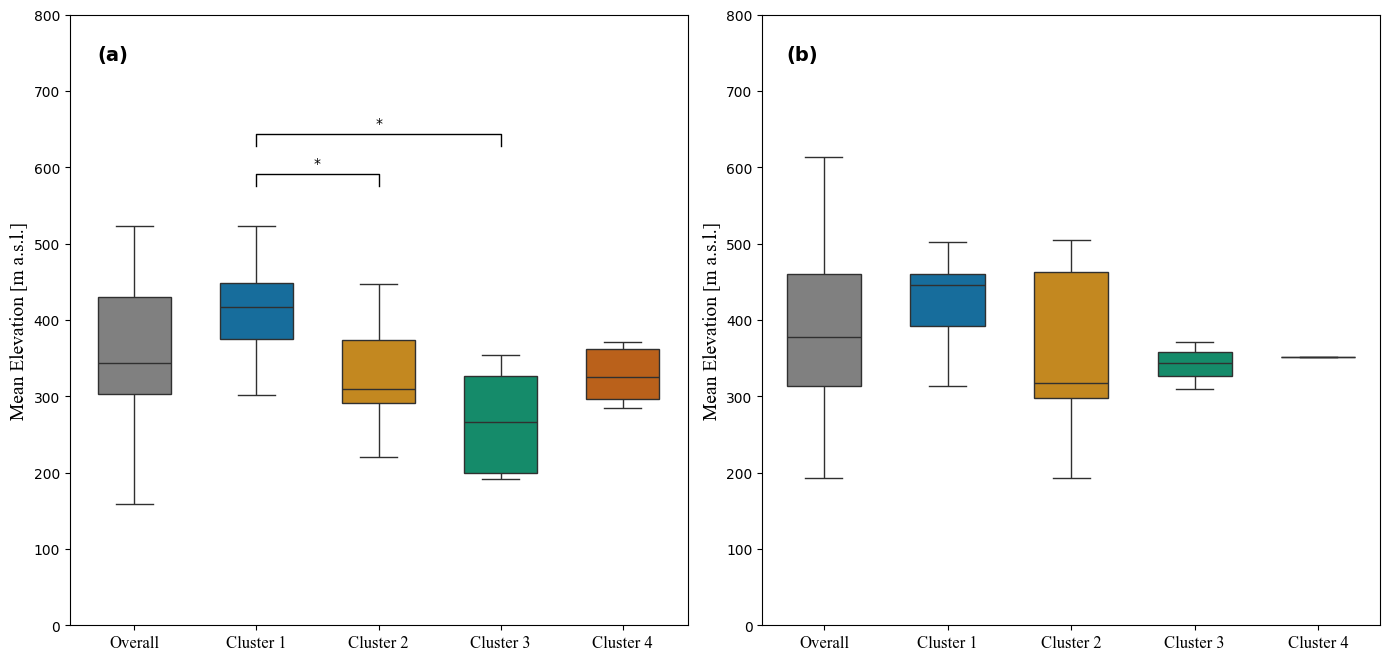

Number of significant pairs: 2


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hohen_stats.xlsx'
data = pd.read_excel(file_path, sheet_name='dgm_zonal_stats')

# Filter 
ges_ezg = data[data['ezg_id'] == 'ges_ezg']
teil_ezg = data[data['ezg_id'] == 'teil_ezg']

# Farbpalette
colorblind_palette = sns.color_palette("colorblind")
selected_colors = ['grey'] + [colorblind_palette[i] for i in [0, 1, 2, 3]]  # Grey for overall, then blue, orange, green, red

# Provided statistical results
stat_results = {
    'ges_ezg': {
        'kruskal_stat': 25.53943066,
        'kruskal_p': 1.19078E-05,
        'dunn': {
            (1, 2): 0.000551142,
            (1, 3): 0.000251055,
        }
    },
    'teil_ezg': {
        'kruskal_stat': None,
        'kruskal_p': None,
        'dunn': {}
    },
}


def create_boxplots(data, filename):
    # Set size
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

    
    axes = axes.flatten()

    
    datasets = [ges_ezg, teil_ezg]
    titles = ['ges_ezg', 'teil_ezg']
    significant_pairs_count = 0  # Counter for significant pairs

    for i, subset in enumerate(datasets):
        
        overall_data = subset.copy()
        overall_data['cluster_combined'] = 'Overall'
        combined_data = pd.concat([overall_data, subset.assign(cluster_combined=subset['cluster'].astype(str).replace({'1': 'Cluster 1', '2': 'Cluster 2', '3': 'Cluster 3', '4': 'Cluster 4'}))])

        # Boxplots for each cluster including overall 
        sns.boxplot(x='cluster_combined', y='mean', data=combined_data, ax=axes[i], palette=selected_colors, width=0.6, showfliers=False)
        
        # Add label 
        axes[i].text(-0.3, 760, '(a)' if i == 0 else '(b)', fontsize=14, fontweight='bold', va='top', ha='left')
        
        axes[i].set_ylim(0, 800)  # Adjust y-axis
        axes[i].set_ylabel('Mean Elevation [m a.s.l.]', fontsize=14, fontname='Times New Roman')
        axes[i].set_xlabel('', fontsize=14, fontname='Times New Roman')
        axes[i].set_xticklabels(['Overall', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], fontsize=12, fontname='Times New Roman')

        # Set y-ticks
        yticks = axes[i].get_yticks()
        new_yticks = [tick for tick in yticks if tick <= 800]
        axes[i].set_yticks(new_yticks)

        # Add significance markers based on provided results
        if titles[i] in stat_results:
            dunn_results = stat_results[titles[i]]['dunn']
            y_max = combined_data['mean'].max()
            y_step = y_max * 0.1  # Space between markers

            for idx, ((x1, x2), p_value) in enumerate(dunn_results.items()):
                if p_value < 0.05:
                    significant_pairs_count += 1
                    y = y_max + y_step * (idx + 1)
                    axes[i].plot([x1, x1, x2, x2], [y, y + y_step * 0.3, y + y_step * 0.3, y], lw=1, c='black')
                    axes[i].text((x1 + x2) * .5, y + y_step * 0.4, "*", ha='center', va='bottom', color='black', fontsize=10)

    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, format='svg')
    plt.show()

    print(f"Number of significant pairs: {significant_pairs_count}")

output_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/Abbildungen/'
create_boxplots(data, output_path + 'mean_elevation_significant_ges_ezg.svg')


### ELEVATION STATISTICS

In [220]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp


file_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/hohen_stats.xlsx'
data = pd.read_excel(file_path, sheet_name='dgm_zonal_stats')

soil_categories = ['mean']

# Filter 
ges_ezg_data = data[data['ezg_id'] == 'ges_ezg']
teil_ezg_data = data[data['ezg_id'] == 'teil_ezg']


def perform_statistical_tests(data):
    numeric_data = data[soil_categories]
    clusters = data['cluster']
    results = []
    
    for col in numeric_data.columns:
        unit = col
        cluster_groups = [numeric_data[col][clusters == cluster_num].dropna() for cluster_num in range(1, 5)]
        
        # Check for variability 
        if all(group.nunique() > 1 for group in cluster_groups if len(group) > 0):
            # Kruskal-Wallis Test
            kruskal_result = stats.kruskal(*cluster_groups)
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': kruskal_result.statistic,
                'P-Value': kruskal_result.pvalue,
                'Note': 'Significant differences' if kruskal_result.pvalue < 0.05 else 'Insufficient variance'
            }
            results.append(pd.DataFrame([result]))
            
            if kruskal_result.pvalue < 0.05:  # Nur wenn signifikant
                dunn_result = sp.posthoc_dunn(cluster_groups, p_adjust='bonferroni')
                dunn_result = dunn_result.melt(var_name='Comparison', value_name='P-Value')
                dunn_result['Test'] = 'Dunn'
                dunn_result['Unit'] = unit
                results.append(dunn_result)
        else:
            result = {
                'Unit': unit,
                'Test': 'Kruskal-Wallis',
                'Statistic': 'N/A',
                'P-Value': 'N/A',
                'Note': 'Insufficient variance'
            }
            results.append(pd.DataFrame([result]))

    return pd.concat(results)

# Perform tests for 'ges_ezg' and 'teil_ezg'
ges_ezg_results = perform_statistical_tests(ges_ezg_data)
teil_ezg_results = perform_statistical_tests(teil_ezg_data)

# Save the results to Excel files
ges_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/elevation_ges_ezg_stats_.xlsx'
teil_ezg_results_path = 'C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/elevation_teil_ezg_stats.xlsx'

ges_ezg_results.to_excel(ges_ezg_results_path, index=False)
teil_ezg_results.to_excel(teil_ezg_results_path, index=False)

print("Results for 'ges_ezg' saved to:", ges_ezg_results_path)
print("Results for 'teil_ezg' saved to:", teil_ezg_results_path)



Results for 'ges_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/elevation_ges_ezg_stats_.xlsx
Results for 'teil_ezg' saved to: C:/Users/Lenovo/Documents/Masterarbeit/Masterarbeit/3_arbeitsordner/PCA/elevation_teil_ezg_stats.xlsx
